In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision as tv
import re
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, GRU, Embedding, Linear, Sigmoid, CrossEntropyLoss, ReLU, Tanh, Sequential
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [3]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [30]:
fmnist = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
data_loader = DataLoader(fmnist, batch_size=batch_size, shuffle=True)

In [31]:
class Generator(Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = Sequential(
            Linear(self.nz, 256),
            ReLU(),

            Linear(256, 512),
            ReLU(),

            Linear(512, 784),
            Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


In [32]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = Sequential(
            Linear(self.n_input, 1024),
            ReLU(),
            Linear(1024, 512),
            ReLU(),
            Linear(512, 1),
            # nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

Initialize the Neural Networks and Define the Optimizers

In [33]:


generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)
######################


In [34]:
# optimizers
# optim_g = optim.RMSprop(generator.parameters(), lr=0.0001)
# optim_d = optim.RMSprop(discriminator.parameters(), lr=0.0001)
optim_g = optim.RMSprop(generator.parameters(), lr=0.0001, weight_decay=0.1)
optim_d = optim.RMSprop(discriminator.parameters(), lr=0.0001, weight_decay=0.1)

In [10]:
# loss function
# criterion = nn.BCELoss()


In [35]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [36]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [37]:
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [38]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [46]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    # b_size = data_real.size(0)
    # real_label = label_real(b_size)
    # fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    # loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss = -(torch.mean(output_real) - torch.mean(output_fake))
    # loss_fake = criterion(output_fake, fake_label)
    loss.backward()
    optimizer.step()
    return loss

In [40]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    # b_size = data_fake.size(0)
    # real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = -torch.mean(output)
    loss.backward()
    optimizer.step()
    return loss

In [41]:
# create the noise vector
noise = create_noise(sample_size, nz)
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
path = "/content/drive/MyDrive/Deep_Learning/HW3/outputs_wasserstein/"
# path = ""
epochs = 200
c = 0.01
# k = 10

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(data_loader), total=int(len(fmnist)/data_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            # print(create_noise(b_size, nz).shape)
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    # noise = create_noise(b_size, nz)
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, path + f"gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    for p in discriminator.parameters():
        p.data.clamp_(-c, c)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")




  0%|          | 0/117 [00:00<?, ?it/s]


  2%|▏         | 2/117 [00:00<00:08, 13.42it/s]


  3%|▎         | 4/117 [00:00<00:08, 12.91it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.60it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.86it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.64it/s]


 10%|█         | 12/117 [00:00<00:08, 12.58it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.77it/s]


 14%|█▎        | 16/117 [00:01<00:07, 12.75it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.34it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.25it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.53it/s]


 21%|██        | 24/117 [00:01<00:07, 12.24it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.49it/s]


 24%|██▍       | 28/117 [00:02<00:06, 12.75it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.82it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.70it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.68it/s]


 31%|███       | 36/117 [00:02<00:06, 12.51it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.

Epoch 0 of 200
Generator loss: -24.76252556, Discriminator loss: -3.36000061





  3%|▎         | 4/117 [00:00<00:08, 13.16it/s]


  5%|▌         | 6/117 [00:00<00:08, 13.15it/s]


  7%|▋         | 8/117 [00:00<00:08, 13.22it/s]


  9%|▊         | 10/117 [00:00<00:08, 13.13it/s]


 10%|█         | 12/117 [00:00<00:07, 13.40it/s]


 12%|█▏        | 14/117 [00:01<00:07, 13.19it/s]


 14%|█▎        | 16/117 [00:01<00:07, 13.24it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.98it/s]


 17%|█▋        | 20/117 [00:01<00:07, 13.11it/s]


 19%|█▉        | 22/117 [00:01<00:07, 13.16it/s]


 21%|██        | 24/117 [00:01<00:07, 13.03it/s]


 22%|██▏       | 26/117 [00:01<00:07, 12.97it/s]


 24%|██▍       | 28/117 [00:02<00:06, 12.84it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.70it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.69it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.95it/s]


 31%|███       | 36/117 [00:02<00:06, 12.16it/s]


 32%|███▏      | 38/117 [00:02<00:06, 12.44it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.64it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 1 of 200
Generator loss: 4.75412226, Discriminator loss: -4.93920040





  3%|▎         | 4/117 [00:00<00:08, 13.15it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.95it/s]


  7%|▋         | 8/117 [00:00<00:08, 13.06it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.77it/s]


 10%|█         | 12/117 [00:00<00:08, 12.83it/s]


 12%|█▏        | 14/117 [00:01<00:07, 12.89it/s]


 14%|█▎        | 16/117 [00:01<00:07, 12.75it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.63it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.77it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.80it/s]


 21%|██        | 24/117 [00:01<00:07, 12.94it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.83it/s]


 24%|██▍       | 28/117 [00:02<00:06, 12.79it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.78it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.77it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.75it/s]


 31%|███       | 36/117 [00:02<00:06, 12.65it/s]


 32%|███▏      | 38/117 [00:02<00:06, 12.39it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.59it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 2 of 200
Generator loss: -9.58885574, Discriminator loss: -1.25719082





  3%|▎         | 4/117 [00:00<00:09, 12.53it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.91it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.70it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.18it/s]


 10%|█         | 12/117 [00:00<00:08, 12.34it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.57it/s]


 14%|█▎        | 16/117 [00:01<00:07, 12.71it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.81it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.56it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.57it/s]


 21%|██        | 24/117 [00:01<00:07, 12.74it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.85it/s]


 24%|██▍       | 28/117 [00:02<00:06, 12.93it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.78it/s]


 27%|██▋       | 32/117 [00:02<00:06, 13.02it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.85it/s]


 31%|███       | 36/117 [00:02<00:06, 12.90it/s]


 32%|███▏      | 38/117 [00:02<00:06, 12.98it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.80it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 3 of 200
Generator loss: -0.51744348, Discriminator loss: -2.63692975





  3%|▎         | 4/117 [00:00<00:08, 12.65it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.57it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.64it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.90it/s]


 10%|█         | 12/117 [00:00<00:08, 12.68it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.82it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.59it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.74it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.47it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.74it/s]


 21%|██        | 24/117 [00:01<00:07, 12.70it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.72it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.55it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.55it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.40it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.67it/s]


 31%|███       | 36/117 [00:02<00:06, 12.97it/s]


 32%|███▏      | 38/117 [00:02<00:06, 13.03it/s]


 34%|███▍      | 40/117 [00:03<00:05, 13.17it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 4 of 200
Generator loss: -1.38011122, Discriminator loss: -2.09687233





  3%|▎         | 4/117 [00:00<00:08, 13.40it/s]


  5%|▌         | 6/117 [00:00<00:08, 13.21it/s]


  7%|▋         | 8/117 [00:00<00:08, 13.24it/s]


  9%|▊         | 10/117 [00:00<00:08, 13.03it/s]


 10%|█         | 12/117 [00:00<00:08, 12.66it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.72it/s]


 14%|█▎        | 16/117 [00:01<00:07, 12.82it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.67it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.81it/s]


 19%|█▉        | 22/117 [00:01<00:07, 13.01it/s]


 21%|██        | 24/117 [00:01<00:07, 13.03it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.86it/s]


 24%|██▍       | 28/117 [00:02<00:06, 12.95it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.84it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.84it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.89it/s]


 31%|███       | 36/117 [00:02<00:06, 12.87it/s]


 32%|███▏      | 38/117 [00:02<00:06, 12.94it/s]


 34%|███▍      | 40/117 [00:03<00:05, 13.02it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 5 of 200
Generator loss: -2.70859003, Discriminator loss: -3.93616104





  3%|▎         | 4/117 [00:00<00:08, 13.31it/s]


  5%|▌         | 6/117 [00:00<00:08, 13.24it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.97it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.97it/s]


 10%|█         | 12/117 [00:00<00:08, 12.92it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.76it/s]


 14%|█▎        | 16/117 [00:01<00:07, 13.00it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.63it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.48it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.72it/s]


 21%|██        | 24/117 [00:01<00:07, 12.74it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.72it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.54it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.30it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.52it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.65it/s]


 31%|███       | 36/117 [00:02<00:06, 12.60it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.46it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.47it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 6 of 200
Generator loss: -4.80616570, Discriminator loss: -3.59767151





  3%|▎         | 4/117 [00:00<00:08, 12.74it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.94it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.69it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.69it/s]


 10%|█         | 12/117 [00:00<00:08, 12.77it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.74it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.44it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.65it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.55it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.62it/s]


 21%|██        | 24/117 [00:01<00:07, 12.48it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.47it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.30it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.45it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.55it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.69it/s]


 31%|███       | 36/117 [00:02<00:06, 12.89it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.84it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.75it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 7 of 200
Generator loss: -0.59968960, Discriminator loss: -2.03052878





  3%|▎         | 4/117 [00:00<00:08, 13.78it/s]


  5%|▌         | 6/117 [00:00<00:08, 13.54it/s]


  7%|▋         | 8/117 [00:00<00:08, 13.21it/s]


  9%|▊         | 10/117 [00:00<00:08, 13.14it/s]


 10%|█         | 12/117 [00:00<00:08, 12.95it/s]


 12%|█▏        | 14/117 [00:01<00:07, 13.16it/s]


 14%|█▎        | 16/117 [00:01<00:07, 12.82it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.93it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.73it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.89it/s]


 21%|██        | 24/117 [00:01<00:07, 12.80it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.39it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.50it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.77it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.54it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.70it/s]


 31%|███       | 36/117 [00:02<00:06, 12.79it/s]


 32%|███▏      | 38/117 [00:02<00:06, 12.39it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.49it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 8 of 200
Generator loss: -0.39857084, Discriminator loss: -2.84508133





  3%|▎         | 4/117 [00:00<00:08, 13.18it/s]


  5%|▌         | 6/117 [00:00<00:08, 13.20it/s]


  7%|▋         | 8/117 [00:00<00:08, 13.00it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.44it/s]


 10%|█         | 12/117 [00:00<00:08, 12.63it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.76it/s]


 14%|█▎        | 16/117 [00:01<00:07, 12.66it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.55it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.50it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.60it/s]


 21%|██        | 24/117 [00:01<00:07, 12.69it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.68it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.61it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.44it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.70it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.87it/s]


 31%|███       | 36/117 [00:02<00:06, 12.80it/s]


 32%|███▏      | 38/117 [00:02<00:06, 13.03it/s]


 34%|███▍      | 40/117 [00:03<00:05, 12.84it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 9 of 200
Generator loss: -2.44709325, Discriminator loss: -3.80639100





  3%|▎         | 4/117 [00:00<00:08, 13.09it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.96it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.57it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.53it/s]


 10%|█         | 12/117 [00:00<00:08, 12.62it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.75it/s]


 14%|█▎        | 16/117 [00:01<00:07, 12.78it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.67it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.53it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.37it/s]


 21%|██        | 24/117 [00:01<00:07, 12.54it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.24it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.27it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.53it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.55it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.65it/s]


 31%|███       | 36/117 [00:02<00:06, 12.69it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.60it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.58it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 10 of 200
Generator loss: -2.84777761, Discriminator loss: -2.19847035





  3%|▎         | 4/117 [00:00<00:09, 12.45it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.24it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.31it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.54it/s]


 10%|█         | 12/117 [00:00<00:08, 12.60it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.65it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.41it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.15it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.46it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.41it/s]


 21%|██        | 24/117 [00:01<00:07, 12.46it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.34it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.40it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.58it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.71it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.64it/s]


 31%|███       | 36/117 [00:02<00:06, 12.55it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.57it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.73it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 11 of 200
Generator loss: -3.93212938, Discriminator loss: -2.61350536





  3%|▎         | 4/117 [00:00<00:08, 13.12it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.99it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.92it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.92it/s]


 10%|█         | 12/117 [00:00<00:08, 12.51it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.08it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.38it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.59it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.65it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.67it/s]


 21%|██        | 24/117 [00:01<00:07, 12.79it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.34it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.46it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.67it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.85it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.89it/s]


 31%|███       | 36/117 [00:02<00:06, 13.04it/s]


 32%|███▏      | 38/117 [00:02<00:06, 12.86it/s]


 34%|███▍      | 40/117 [00:03<00:05, 12.96it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 12 of 200
Generator loss: -5.46874762, Discriminator loss: -2.80928969





  3%|▎         | 4/117 [00:00<00:08, 12.86it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.97it/s]


  7%|▋         | 8/117 [00:00<00:08, 13.01it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.71it/s]


  9%|▉         | 11/117 [00:00<00:08, 11.95it/s]


 11%|█         | 13/117 [00:01<00:08, 12.26it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.49it/s]


 15%|█▍        | 17/117 [00:01<00:07, 12.71it/s]


 16%|█▌        | 19/117 [00:01<00:07, 12.62it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.36it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.23it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.20it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.34it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.18it/s]


 26%|██▋       | 31/117 [00:02<00:06, 12.34it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.49it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.38it/s]


 32%|███▏      | 37/117 [00:02<00:06, 12.36it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.37it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 13 of 200
Generator loss: -3.45236182, Discriminator loss: -4.49526596





  3%|▎         | 4/117 [00:00<00:08, 12.62it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.72it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.65it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.61it/s]


 10%|█         | 12/117 [00:00<00:08, 12.39it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.73it/s]


 14%|█▎        | 16/117 [00:01<00:07, 12.74it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.85it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.63it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.77it/s]


 21%|██        | 24/117 [00:01<00:07, 12.81it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.78it/s]


 24%|██▍       | 28/117 [00:02<00:06, 12.89it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.88it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.89it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.81it/s]


 31%|███       | 36/117 [00:02<00:06, 12.75it/s]


 32%|███▏      | 38/117 [00:02<00:06, 12.81it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.57it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 14 of 200
Generator loss: -2.94118428, Discriminator loss: -4.08267784





  3%|▎         | 4/117 [00:00<00:08, 12.65it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.84it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.71it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.51it/s]


 10%|█         | 12/117 [00:00<00:08, 12.43it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.69it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.62it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.77it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.80it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.54it/s]


 21%|██        | 24/117 [00:01<00:07, 12.42it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.29it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.42it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.32it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.46it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.17it/s]


 31%|███       | 36/117 [00:02<00:06, 12.41it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.58it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.64it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 15 of 200
Generator loss: -3.53684187, Discriminator loss: -3.87245941





  3%|▎         | 4/117 [00:00<00:08, 13.28it/s]


  5%|▌         | 6/117 [00:00<00:08, 13.09it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.87it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.86it/s]


 10%|█         | 12/117 [00:00<00:08, 12.72it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.67it/s]


 14%|█▎        | 16/117 [00:01<00:07, 12.75it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.60it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.53it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.57it/s]


 21%|██        | 24/117 [00:01<00:07, 12.38it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.18it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.18it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.44it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.51it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.54it/s]


 31%|███       | 36/117 [00:02<00:06, 12.59it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.39it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.49it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 16 of 200
Generator loss: -4.26772261, Discriminator loss: -4.37496614





  3%|▎         | 4/117 [00:00<00:08, 12.86it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.64it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.32it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.41it/s]


 10%|█         | 12/117 [00:00<00:08, 12.37it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.51it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.58it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.33it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.44it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.35it/s]


 21%|██        | 24/117 [00:01<00:07, 12.31it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.24it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.26it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.23it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.14it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.15it/s]


 31%|███       | 36/117 [00:02<00:06, 12.30it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.37it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.44it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 17 of 200
Generator loss: -2.66869473, Discriminator loss: -5.37217379





  3%|▎         | 4/117 [00:00<00:09, 12.37it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.37it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.42it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.30it/s]


 10%|█         | 12/117 [00:00<00:08, 12.48it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.34it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.23it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.18it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.48it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.56it/s]


 21%|██        | 24/117 [00:01<00:07, 12.45it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.64it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.52it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.66it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.76it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.82it/s]


 31%|███       | 36/117 [00:02<00:06, 12.59it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.68it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.51it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 18 of 200
Generator loss: -2.91534710, Discriminator loss: -5.23663807





  3%|▎         | 4/117 [00:00<00:09, 12.37it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.43it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.26it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.31it/s]


 10%|█         | 12/117 [00:00<00:08, 12.28it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.39it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.13it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.18it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.24it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.46it/s]


 21%|██        | 24/117 [00:01<00:07, 12.23it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.45it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.43it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.17it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.39it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.42it/s]


 31%|███       | 36/117 [00:02<00:06, 12.39it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.38it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.62it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 19 of 200
Generator loss: -4.59129190, Discriminator loss: -3.62024498





  3%|▎         | 4/117 [00:00<00:09, 12.35it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.32it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.24it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.26it/s]


 10%|█         | 12/117 [00:01<00:08, 11.94it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.20it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.97it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.20it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.45it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.27it/s]


 21%|██        | 24/117 [00:01<00:07, 12.15it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.37it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.51it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.02it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.19it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.32it/s]


 31%|███       | 36/117 [00:02<00:06, 12.40it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.54it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.07it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 20 of 200
Generator loss: 0.04193330, Discriminator loss: -3.85949564





  3%|▎         | 4/117 [00:00<00:09, 12.32it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.35it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.56it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.64it/s]


 10%|█         | 12/117 [00:00<00:08, 12.23it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.42it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.53it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.64it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.55it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.40it/s]


 21%|██        | 24/117 [00:01<00:07, 12.48it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.48it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.60it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.37it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.43it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.64it/s]


 31%|███       | 36/117 [00:02<00:06, 12.33it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.50it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.32it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 21 of 200
Generator loss: -2.27264333, Discriminator loss: -3.01226807





  3%|▎         | 4/117 [00:00<00:09, 11.59it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.77it/s]


  7%|▋         | 8/117 [00:00<00:09, 12.09it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.29it/s]


 10%|█         | 12/117 [00:00<00:08, 12.21it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.34it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.60it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.23it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.45it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.20it/s]


 21%|██        | 24/117 [00:01<00:07, 12.14it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.33it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.55it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.47it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.13it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.40it/s]


 31%|███       | 36/117 [00:02<00:06, 12.29it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.54it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.60it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 22 of 200
Generator loss: -5.10252428, Discriminator loss: -3.27605510





  3%|▎         | 4/117 [00:00<00:09, 12.04it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.10it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.13it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.16it/s]


 10%|█         | 12/117 [00:01<00:08, 11.96it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.13it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.18it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.24it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.31it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.43it/s]


 21%|██        | 24/117 [00:01<00:07, 12.19it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.21it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.14it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.11it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.02it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.16it/s]


 31%|███       | 36/117 [00:02<00:06, 12.09it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.14it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.00it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 23 of 200
Generator loss: -3.03142643, Discriminator loss: -3.52622437





  3%|▎         | 3/117 [00:00<00:09, 11.98it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.78it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.81it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.96it/s]


  9%|▉         | 11/117 [00:00<00:08, 12.05it/s]


 11%|█         | 13/117 [00:01<00:08, 11.94it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.13it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.24it/s]


 16%|█▌        | 19/117 [00:01<00:07, 12.34it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.43it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.33it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.18it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.20it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.38it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.25it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.15it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.27it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.38it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.20it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 24 of 200
Generator loss: -2.97434139, Discriminator loss: -3.54231787





  3%|▎         | 4/117 [00:00<00:09, 12.55it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.50it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.76it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.91it/s]


  9%|▉         | 11/117 [00:00<00:08, 12.04it/s]


 11%|█         | 13/117 [00:01<00:08, 12.26it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.87it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.21it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.14it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.13it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.06it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.93it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.15it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.14it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.83it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.02it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.24it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.98it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.19it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 25 of 200
Generator loss: -3.96752381, Discriminator loss: -3.69576597





  3%|▎         | 4/117 [00:00<00:09, 12.53it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.47it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.59it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.75it/s]


 10%|█         | 12/117 [00:01<00:08, 11.94it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.28it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.20it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.13it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.30it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.18it/s]


 21%|██        | 24/117 [00:02<00:07, 12.29it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.42it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.60it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.28it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.55it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.57it/s]


 31%|███       | 36/117 [00:02<00:06, 12.34it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.43it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.57it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 26 of 200
Generator loss: -3.47270799, Discriminator loss: -3.55976510





  3%|▎         | 4/117 [00:00<00:09, 12.34it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.51it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.57it/s]


  7%|▋         | 8/117 [00:00<00:09, 10.96it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.24it/s]


 10%|█         | 12/117 [00:01<00:09, 11.58it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.76it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.02it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.86it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.19it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.45it/s]


 21%|██        | 24/117 [00:02<00:08, 11.56it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.42it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.69it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.74it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.98it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.96it/s]


 31%|███       | 36/117 [00:03<00:06, 12.05it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.02it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 27 of 200
Generator loss: -3.09281993, Discriminator loss: -3.32427788





  3%|▎         | 3/117 [00:00<00:09, 11.61it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.87it/s]


  6%|▌         | 7/117 [00:00<00:09, 12.05it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.95it/s]


  9%|▉         | 11/117 [00:00<00:08, 12.16it/s]


 11%|█         | 13/117 [00:01<00:08, 12.09it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.18it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.10it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.09it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.24it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.22it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.53it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.66it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.20it/s]


 26%|██▋       | 31/117 [00:02<00:06, 12.32it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.14it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.29it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.97it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.12it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 28 of 200
Generator loss: -4.14187622, Discriminator loss: -2.88193822





  3%|▎         | 3/117 [00:00<00:09, 11.51it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.99it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.48it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.62it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.86it/s]


 10%|█         | 12/117 [00:01<00:08, 12.00it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.16it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.94it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.42it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.73it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.70it/s]


 21%|██        | 24/117 [00:02<00:07, 11.64it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.89it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.19it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.34it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.98it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.10it/s]


 31%|███       | 36/117 [00:03<00:06, 12.09it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.96it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 29 of 200
Generator loss: -0.83119011, Discriminator loss: -0.70395988





  3%|▎         | 3/117 [00:00<00:09, 11.42it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.50it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.69it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.77it/s]


  9%|▉         | 11/117 [00:00<00:08, 11.91it/s]


 11%|█         | 13/117 [00:01<00:08, 11.73it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.96it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.08it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.19it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.39it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.45it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.57it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.48it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.21it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.15it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.15it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.21it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.39it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.24it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 30 of 200
Generator loss: -1.86436486, Discriminator loss: -2.56405282





  3%|▎         | 4/117 [00:00<00:09, 12.31it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.47it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.52it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.44it/s]


 10%|█         | 12/117 [00:00<00:08, 12.51it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.41it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.40it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.08it/s]


 17%|█▋        | 20/117 [00:01<00:08, 12.06it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.30it/s]


 21%|██        | 24/117 [00:01<00:07, 11.95it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.06it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.17it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.98it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.85it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.96it/s]


 31%|███       | 36/117 [00:02<00:06, 12.20it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.43it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.27it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 31 of 200
Generator loss: -2.94692254, Discriminator loss: -3.64161515





  3%|▎         | 4/117 [00:00<00:08, 12.71it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.44it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.52it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.30it/s]


 10%|█         | 12/117 [00:00<00:08, 12.39it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.08it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.95it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.20it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.13it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.67it/s]


 21%|██        | 24/117 [00:01<00:07, 11.77it/s]


 22%|██▏       | 26/117 [00:02<00:08, 10.82it/s]


 24%|██▍       | 28/117 [00:02<00:08, 11.10it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.43it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.73it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.77it/s]


 31%|███       | 36/117 [00:03<00:06, 11.98it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.96it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.07it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 32 of 200
Generator loss: -3.94075346, Discriminator loss: -1.63263607





  3%|▎         | 3/117 [00:00<00:10, 11.39it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.88it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.16it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.41it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.83it/s]


 10%|█         | 12/117 [00:01<00:08, 11.88it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.96it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.09it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.26it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.35it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.20it/s]


 21%|██        | 24/117 [00:01<00:07, 12.43it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.55it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.35it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.31it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.43it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.27it/s]


 31%|███       | 36/117 [00:02<00:06, 12.28it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.32it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 33 of 200
Generator loss: -1.69612956, Discriminator loss: -2.68410635





  3%|▎         | 4/117 [00:00<00:09, 12.35it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.27it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.49it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.87it/s]


  9%|▉         | 11/117 [00:00<00:08, 11.98it/s]


 11%|█         | 13/117 [00:01<00:08, 12.28it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.06it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.27it/s]


 16%|█▌        | 19/117 [00:01<00:07, 12.57it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.62it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.26it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.24it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.37it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.43it/s]


 26%|██▋       | 31/117 [00:02<00:06, 12.56it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.20it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.39it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.14it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.21it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 34 of 200
Generator loss: -2.20102000, Discriminator loss: -2.96901131





  3%|▎         | 4/117 [00:00<00:09, 12.04it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.81it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.75it/s]


  9%|▊         | 10/117 [00:00<00:08, 11.89it/s]


 10%|█         | 12/117 [00:01<00:08, 11.91it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.93it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.88it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.97it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.14it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.03it/s]


 21%|██        | 24/117 [00:02<00:07, 12.01it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.19it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.02it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.16it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.91it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.02it/s]


 31%|███       | 36/117 [00:03<00:07, 11.03it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.44it/s]


 34%|███▍      | 40/117 [00:03<00:06, 11.34it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 35 of 200
Generator loss: -2.20420504, Discriminator loss: -3.34674382





  3%|▎         | 4/117 [00:00<00:09, 12.43it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.24it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.24it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.16it/s]


 10%|█         | 12/117 [00:00<00:08, 12.22it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.66it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.00it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.98it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.93it/s]


 19%|█▉        | 22/117 [00:01<00:07, 11.89it/s]


 21%|██        | 24/117 [00:01<00:07, 12.15it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.15it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.38it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.58it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.20it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.26it/s]


 31%|███       | 36/117 [00:02<00:06, 12.35it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.37it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.20it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 36 of 200
Generator loss: -3.26433015, Discriminator loss: -1.96352446





  3%|▎         | 4/117 [00:00<00:09, 12.09it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.09it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.18it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.19it/s]


 10%|█         | 12/117 [00:00<00:08, 12.16it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.88it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.93it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.14it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.28it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.29it/s]


 21%|██        | 24/117 [00:01<00:07, 12.29it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.28it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.10it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.14it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.10it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.10it/s]


 31%|███       | 36/117 [00:02<00:06, 12.23it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.83it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.04it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 37 of 200
Generator loss: -1.68506086, Discriminator loss: -2.03907347





  3%|▎         | 4/117 [00:00<00:08, 12.77it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.57it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.64it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.60it/s]


 10%|█         | 12/117 [00:00<00:08, 12.56it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.39it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.33it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.20it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.99it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.00it/s]


 21%|██        | 24/117 [00:01<00:07, 12.04it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.14it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.07it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.09it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.94it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.16it/s]


 31%|███       | 36/117 [00:02<00:06, 12.12it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.15it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.03it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 38 of 200
Generator loss: -1.46926284, Discriminator loss: -2.60530949





  3%|▎         | 3/117 [00:00<00:09, 11.40it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.63it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.68it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.93it/s]


  9%|▉         | 11/117 [00:00<00:08, 11.80it/s]


 11%|█         | 13/117 [00:01<00:08, 12.06it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.09it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.18it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.14it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.26it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.97it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.03it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.22it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.02it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.84it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.76it/s]


 30%|██▉       | 35/117 [00:02<00:07, 11.71it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.76it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.09it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 39 of 200
Generator loss: -1.98137856, Discriminator loss: -2.53393149





  3%|▎         | 3/117 [00:00<00:09, 11.73it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.75it/s]


  6%|▌         | 7/117 [00:00<00:09, 12.17it/s]


  8%|▊         | 9/117 [00:00<00:08, 12.25it/s]


  9%|▉         | 11/117 [00:00<00:08, 12.11it/s]


 11%|█         | 13/117 [00:01<00:08, 11.87it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.79it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.95it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.23it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.38it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.36it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.88it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.92it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.99it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.25it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.33it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.46it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.40it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.35it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 40 of 200
Generator loss: -2.47557449, Discriminator loss: -2.04720664





  3%|▎         | 4/117 [00:00<00:08, 12.57it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.25it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.24it/s]


  9%|▊         | 10/117 [00:00<00:08, 11.90it/s]


 10%|█         | 12/117 [00:01<00:08, 12.00it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.18it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.13it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.30it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.29it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.87it/s]


 21%|██        | 24/117 [00:01<00:07, 11.99it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.17it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.21it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.17it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.08it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.87it/s]


 31%|███       | 36/117 [00:03<00:06, 11.57it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.85it/s]


 34%|███▍      | 40/117 [00:03<00:06, 11.86it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 41 of 200
Generator loss: -3.33480048, Discriminator loss: -1.83478320





  3%|▎         | 4/117 [00:00<00:08, 13.09it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.98it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.62it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.57it/s]


 10%|█         | 12/117 [00:00<00:08, 12.35it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.03it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.35it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.31it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.25it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.53it/s]


 21%|██        | 24/117 [00:01<00:07, 12.17it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.97it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.35it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.26it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.35it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.34it/s]


 31%|███       | 36/117 [00:02<00:06, 12.27it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.43it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.38it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 42 of 200
Generator loss: -2.44000840, Discriminator loss: -2.47718096





  3%|▎         | 4/117 [00:00<00:09, 11.63it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.05it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.17it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.32it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.63it/s]


 11%|█         | 13/117 [00:01<00:08, 11.74it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.04it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.19it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.16it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.11it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.11it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.22it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.17it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.12it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.21it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.20it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.86it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.03it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.01it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 43 of 200
Generator loss: -1.04730427, Discriminator loss: -3.30315590





  3%|▎         | 4/117 [00:00<00:09, 11.73it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.12it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.17it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.08it/s]


 10%|█         | 12/117 [00:00<00:08, 12.35it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.00it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.15it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.35it/s]


 17%|█▋        | 20/117 [00:01<00:08, 12.09it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.22it/s]


 21%|██        | 24/117 [00:01<00:07, 12.39it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.09it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.72it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.12it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.44it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.40it/s]


 31%|███       | 36/117 [00:02<00:06, 12.33it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.21it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.11it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 44 of 200
Generator loss: -2.17514801, Discriminator loss: -3.36151433





  3%|▎         | 4/117 [00:00<00:09, 12.40it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.12it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.98it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.21it/s]


 10%|█         | 12/117 [00:00<00:08, 12.31it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.04it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.19it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.29it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.99it/s]


 19%|█▉        | 22/117 [00:01<00:07, 11.99it/s]


 21%|██        | 24/117 [00:02<00:07, 11.84it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.05it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.09it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.30it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.05it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.25it/s]


 31%|███       | 36/117 [00:02<00:06, 12.30it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.51it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.17it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 45 of 200
Generator loss: -1.73022950, Discriminator loss: -3.13932729





  3%|▎         | 4/117 [00:00<00:08, 13.12it/s]


  5%|▌         | 6/117 [00:00<00:08, 12.90it/s]


  7%|▋         | 8/117 [00:00<00:08, 12.83it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.71it/s]


 10%|█         | 12/117 [00:00<00:08, 12.45it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.37it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.29it/s]


 15%|█▌        | 18/117 [00:01<00:07, 12.47it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.50it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.51it/s]


 21%|██        | 24/117 [00:01<00:07, 12.46it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.95it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.16it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.31it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.50it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.13it/s]


 31%|███       | 36/117 [00:02<00:06, 12.25it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.21it/s]


 34%|███▍      | 40/117 [00:03<00:06, 12.40it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 46 of 200
Generator loss: -2.33785820, Discriminator loss: -3.14526129





  3%|▎         | 3/117 [00:00<00:09, 11.81it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.82it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.27it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.59it/s]


  9%|▊         | 10/117 [00:00<00:08, 11.91it/s]


 10%|█         | 12/117 [00:01<00:08, 11.77it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.74it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.17it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.14it/s]


 17%|█▋        | 20/117 [00:01<00:08, 12.10it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.04it/s]


 21%|██        | 24/117 [00:01<00:07, 12.30it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.34it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.28it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.17it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.23it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.01it/s]


 31%|███       | 36/117 [00:02<00:06, 12.19it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.15it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 47 of 200
Generator loss: -2.18809414, Discriminator loss: -3.18928766





  3%|▎         | 3/117 [00:00<00:10, 10.76it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.49it/s]


  5%|▌         | 6/117 [00:00<00:10, 11.03it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.21it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.55it/s]


 10%|█         | 12/117 [00:01<00:08, 11.79it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.97it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.28it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.22it/s]


 17%|█▋        | 20/117 [00:01<00:08, 12.04it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.33it/s]


 21%|██        | 24/117 [00:01<00:07, 12.50it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.40it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.41it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.25it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.40it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.37it/s]


 31%|███       | 36/117 [00:02<00:06, 12.16it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.18it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 48 of 200
Generator loss: -0.84159440, Discriminator loss: -2.90774775





  3%|▎         | 3/117 [00:00<00:11, 10.10it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.63it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.10it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.42it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.72it/s]


 11%|█         | 13/117 [00:01<00:08, 11.83it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.87it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.05it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.88it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.96it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.06it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.04it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.89it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.74it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.66it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.80it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.96it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.02it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.06it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 49 of 200
Generator loss: -1.48819768, Discriminator loss: -2.79562974





  3%|▎         | 4/117 [00:00<00:08, 12.74it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.56it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.73it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.84it/s]


  9%|▉         | 11/117 [00:00<00:08, 11.95it/s]


 11%|█         | 13/117 [00:01<00:08, 11.94it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.98it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.97it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.10it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.78it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.79it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.00it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.04it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.05it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.10it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.92it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.00it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.86it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.08it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 50 of 200
Generator loss: -2.90345836, Discriminator loss: -3.12944937





  3%|▎         | 3/117 [00:00<00:09, 12.02it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.89it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.92it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.64it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.68it/s]


 11%|█         | 13/117 [00:01<00:08, 11.95it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.05it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.96it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.06it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.27it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.49it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.31it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.39it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.44it/s]


 26%|██▋       | 31/117 [00:02<00:06, 12.33it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.24it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.19it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.92it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.03it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 51 of 200
Generator loss: -1.78596973, Discriminator loss: -2.49036980





  3%|▎         | 3/117 [00:00<00:09, 11.47it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.61it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.96it/s]


  8%|▊         | 9/117 [00:00<00:08, 12.23it/s]


  9%|▉         | 11/117 [00:00<00:08, 11.90it/s]


 11%|█         | 13/117 [00:01<00:08, 11.76it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.01it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.83it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.10it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.29it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.30it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.32it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.05it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.09it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.25it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.09it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.82it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.91it/s]


 33%|███▎      | 39/117 [00:03<00:06, 11.84it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 52 of 200
Generator loss: -2.79154563, Discriminator loss: -2.40336275





  3%|▎         | 3/117 [00:00<00:10, 11.40it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.67it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.61it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.91it/s]


  9%|▉         | 11/117 [00:00<00:08, 12.12it/s]


 11%|█         | 13/117 [00:01<00:08, 12.07it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.90it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.98it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.06it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.19it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.36it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.27it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.24it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.94it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.96it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.22it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.04it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.08it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.02it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 53 of 200
Generator loss: -2.32655883, Discriminator loss: -1.93379331





  3%|▎         | 3/117 [00:00<00:09, 11.82it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.95it/s]


  6%|▌         | 7/117 [00:00<00:09, 12.17it/s]


  8%|▊         | 9/117 [00:00<00:08, 12.38it/s]


  9%|▉         | 11/117 [00:00<00:08, 12.55it/s]


 11%|█         | 13/117 [00:01<00:08, 12.40it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.11it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.09it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.69it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.87it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.18it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.05it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.07it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.25it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.05it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.59it/s]


 30%|██▉       | 35/117 [00:02<00:07, 11.69it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.02it/s]


 33%|███▎      | 39/117 [00:03<00:06, 11.97it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 54 of 200
Generator loss: -2.50902200, Discriminator loss: -2.71078229





  3%|▎         | 3/117 [00:00<00:10, 11.24it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.47it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.76it/s]


  8%|▊         | 9/117 [00:00<00:09, 12.00it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.23it/s]


 10%|█         | 12/117 [00:01<00:09, 11.59it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.85it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.06it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.01it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.13it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.23it/s]


 21%|██        | 24/117 [00:01<00:07, 12.18it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.94it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.12it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.23it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.18it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.10it/s]


 31%|███       | 36/117 [00:02<00:06, 11.86it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.23it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 55 of 200
Generator loss: -1.72204471, Discriminator loss: -2.81689739





  3%|▎         | 3/117 [00:00<00:09, 11.54it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.33it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.73it/s]


  8%|▊         | 9/117 [00:00<00:09, 12.00it/s]


  9%|▉         | 11/117 [00:00<00:08, 12.26it/s]


 11%|█         | 13/117 [00:01<00:08, 12.34it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.10it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.16it/s]


 16%|█▌        | 19/117 [00:01<00:07, 12.35it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.32it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.97it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.17it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.30it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.25it/s]


 26%|██▋       | 31/117 [00:02<00:06, 12.31it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.46it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.25it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.20it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.37it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 56 of 200
Generator loss: -1.81503308, Discriminator loss: -2.50460863





  3%|▎         | 4/117 [00:00<00:09, 11.54it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.63it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.78it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.81it/s]


  9%|▉         | 11/117 [00:00<00:09, 10.99it/s]


 11%|█         | 13/117 [00:01<00:10, 10.35it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.82it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.24it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.56it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.66it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.89it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.90it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.79it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.77it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.02it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.12it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.02it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.07it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.16it/s]


 35%|███▌      | 41/117 [00:03<

Epoch 57 of 200
Generator loss: -1.58704603, Discriminator loss: -3.16791940





  3%|▎         | 3/117 [00:00<00:10, 11.19it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.75it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.21it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.32it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.59it/s]


 10%|█         | 12/117 [00:01<00:08, 11.75it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.34it/s]


 14%|█▎        | 16/117 [00:01<00:09, 11.21it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.47it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.67it/s]


 19%|█▉        | 22/117 [00:01<00:07, 11.89it/s]


 21%|██        | 24/117 [00:02<00:07, 11.85it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.04it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.94it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.12it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.24it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.20it/s]


 31%|███       | 36/117 [00:03<00:06, 12.13it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.10it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 58 of 200
Generator loss: -2.23904133, Discriminator loss: -2.51694417





  3%|▎         | 3/117 [00:00<00:10, 10.49it/s]


  3%|▎         | 4/117 [00:00<00:11, 10.23it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.70it/s]


  7%|▋         | 8/117 [00:00<00:09, 10.98it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.61it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.16it/s]


 11%|█         | 13/117 [00:01<00:08, 11.57it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.26it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.53it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.82it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.71it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.97it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.03it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.82it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.35it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.71it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.69it/s]


 30%|██▉       | 35/117 [00:03<00:06, 11.86it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.84it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 59 of 200
Generator loss: -2.70525479, Discriminator loss: -2.27680492





  3%|▎         | 4/117 [00:00<00:09, 11.68it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.69it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.75it/s]


  9%|▊         | 10/117 [00:00<00:08, 12.12it/s]


 10%|█         | 12/117 [00:01<00:08, 12.11it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.03it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.17it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.77it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.77it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.05it/s]


 21%|██        | 24/117 [00:02<00:08, 11.17it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.38it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.20it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.38it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.79it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.81it/s]


 31%|███       | 36/117 [00:03<00:06, 11.93it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.09it/s]


 34%|███▍      | 40/117 [00:03<00:06, 11.88it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 60 of 200
Generator loss: -1.82020068, Discriminator loss: -2.59912300





  3%|▎         | 4/117 [00:00<00:09, 11.62it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.79it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.64it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.77it/s]


 10%|█         | 12/117 [00:01<00:08, 11.96it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.86it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.94it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.74it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.32it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.41it/s]


 21%|██        | 24/117 [00:02<00:07, 11.80it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.79it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.59it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.79it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.72it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.80it/s]


 31%|███       | 36/117 [00:03<00:06, 11.79it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.98it/s]


 34%|███▍      | 40/117 [00:03<00:06, 11.95it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 61 of 200
Generator loss: -1.02278244, Discriminator loss: -3.08284140





  3%|▎         | 3/117 [00:00<00:09, 11.46it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.44it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.55it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.78it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.62it/s]


 11%|█         | 13/117 [00:01<00:09, 11.49it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.65it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.91it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.79it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.78it/s]


 20%|█▉        | 23/117 [00:01<00:08, 11.38it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.73it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.95it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.87it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.11it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.34it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.18it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.23it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.33it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 62 of 200
Generator loss: -2.21646738, Discriminator loss: -2.41427612





  3%|▎         | 4/117 [00:00<00:10, 11.19it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.59it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.76it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.77it/s]


 10%|█         | 12/117 [00:01<00:08, 11.80it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.88it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.63it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.68it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.69it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.81it/s]


 21%|██        | 24/117 [00:02<00:07, 11.65it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.89it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.47it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.85it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.79it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.71it/s]


 31%|███       | 36/117 [00:03<00:06, 11.94it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.64it/s]


 34%|███▍      | 40/117 [00:03<00:06, 11.77it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 63 of 200
Generator loss: -2.34374142, Discriminator loss: -2.89785695





  3%|▎         | 3/117 [00:00<00:10, 11.24it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.73it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.48it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.89it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.25it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.59it/s]


 11%|█         | 13/117 [00:01<00:09, 11.53it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.81it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.84it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.99it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.86it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.98it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.15it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.28it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.94it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.95it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.19it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.31it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.78it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 64 of 200
Generator loss: -1.34529054, Discriminator loss: -2.57422590





  3%|▎         | 3/117 [00:00<00:10, 10.74it/s]


  4%|▍         | 5/117 [00:00<00:10, 11.08it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.55it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.69it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.03it/s]


 10%|█         | 12/117 [00:01<00:09, 11.39it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.61it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.81it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.79it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.91it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.80it/s]


 21%|██        | 24/117 [00:02<00:07, 11.99it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.84it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.73it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.05it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.14it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.09it/s]


 31%|███       | 36/117 [00:03<00:06, 11.64it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.68it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 65 of 200
Generator loss: -2.09979796, Discriminator loss: -2.64364052





  3%|▎         | 4/117 [00:00<00:09, 11.88it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.14it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.95it/s]


  9%|▊         | 10/117 [00:00<00:08, 11.95it/s]


 10%|█         | 12/117 [00:01<00:08, 11.93it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.07it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.93it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.85it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.98it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.12it/s]


 21%|██        | 24/117 [00:02<00:07, 11.98it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.95it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.98it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.97it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.14it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.02it/s]


 31%|███       | 36/117 [00:03<00:06, 11.85it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.48it/s]


 34%|███▍      | 40/117 [00:03<00:06, 11.55it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 66 of 200
Generator loss: -2.41484404, Discriminator loss: -2.41648555





  2%|▏         | 2/117 [00:00<00:13,  8.64it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.40it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.56it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.19it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.63it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.01it/s]


 11%|█         | 13/117 [00:01<00:09, 11.44it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.73it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.53it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.70it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.87it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.00it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.76it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.63it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.78it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.14it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.02it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.93it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.10it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 67 of 200
Generator loss: -1.89450228, Discriminator loss: -2.49756002





  3%|▎         | 3/117 [00:00<00:10, 11.32it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.47it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.66it/s]


  7%|▋         | 8/117 [00:00<00:09, 10.99it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.44it/s]


 10%|█         | 12/117 [00:01<00:09, 11.42it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.64it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.26it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.51it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.71it/s]


 19%|█▉        | 22/117 [00:01<00:07, 11.93it/s]


 21%|██        | 24/117 [00:02<00:07, 11.84it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.84it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.84it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.61it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.86it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.89it/s]


 31%|███       | 36/117 [00:03<00:06, 12.09it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.08it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 68 of 200
Generator loss: -2.54082203, Discriminator loss: -2.74172616





  3%|▎         | 4/117 [00:00<00:09, 11.77it/s]


  5%|▌         | 6/117 [00:00<00:09, 11.88it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.88it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.87it/s]


 10%|█         | 12/117 [00:00<00:08, 12.13it/s]


 12%|█▏        | 14/117 [00:01<00:08, 12.27it/s]


 14%|█▎        | 16/117 [00:01<00:08, 12.27it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.08it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.24it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.13it/s]


 21%|██        | 24/117 [00:01<00:07, 12.30it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.44it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.52it/s]


 26%|██▌       | 30/117 [00:02<00:06, 12.47it/s]


 27%|██▋       | 32/117 [00:02<00:06, 12.22it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.18it/s]


 31%|███       | 36/117 [00:02<00:06, 12.09it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.37it/s]


 34%|███▍      | 40/117 [00:03<00:06, 11.92it/s]


 36%|███▌      | 42/117 [00:03<

Epoch 69 of 200
Generator loss: -1.53400147, Discriminator loss: -2.68297315





  3%|▎         | 4/117 [00:00<00:08, 12.80it/s]


  5%|▌         | 6/117 [00:00<00:09, 12.28it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.44it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.70it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.58it/s]


 11%|█         | 13/117 [00:01<00:08, 11.67it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.19it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.42it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.49it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.40it/s]


 20%|█▉        | 23/117 [00:01<00:08, 11.49it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.66it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.56it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.69it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.98it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.72it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.87it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.86it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.02it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 70 of 200
Generator loss: -1.96024013, Discriminator loss: -2.70116043





  3%|▎         | 4/117 [00:00<00:09, 11.63it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.85it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.25it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.51it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.53it/s]


 11%|█         | 13/117 [00:01<00:08, 11.73it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.00it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.05it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.01it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.79it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.94it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.12it/s]


 23%|██▎       | 27/117 [00:02<00:07, 12.01it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.89it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.15it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.39it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.49it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.29it/s]


 33%|███▎      | 39/117 [00:03<00:06, 12.54it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 71 of 200
Generator loss: -2.76142550, Discriminator loss: -2.35577631





  2%|▏         | 2/117 [00:00<00:12,  9.45it/s]


  3%|▎         | 4/117 [00:00<00:11, 10.17it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.83it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.12it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.73it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.07it/s]


 11%|█         | 13/117 [00:01<00:09, 11.28it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.56it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.69it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.93it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.82it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.77it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.76it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.94it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.16it/s]


 26%|██▋       | 31/117 [00:02<00:06, 12.42it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.06it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.06it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.31it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 72 of 200
Generator loss: -2.59540391, Discriminator loss: -2.56112313





  3%|▎         | 3/117 [00:00<00:10, 10.43it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.90it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.37it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.56it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.75it/s]


 11%|█         | 13/117 [00:01<00:09, 11.51it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.80it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.90it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.78it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.10it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.01it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.95it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.93it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.08it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.99it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.08it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.17it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.96it/s]


 33%|███▎      | 39/117 [00:03<00:06, 11.89it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 73 of 200
Generator loss: -2.11054921, Discriminator loss: -2.41007495





  3%|▎         | 3/117 [00:00<00:10, 10.55it/s]


  4%|▍         | 5/117 [00:00<00:10, 11.07it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.21it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.35it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.61it/s]


 11%|█         | 13/117 [00:01<00:08, 11.74it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.97it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.95it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.81it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.06it/s]


 20%|█▉        | 23/117 [00:01<00:07, 12.01it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.95it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.73it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.82it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.68it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.78it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.92it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.10it/s]


 33%|███▎      | 39/117 [00:03<00:06, 11.91it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 74 of 200
Generator loss: -1.34691501, Discriminator loss: -2.58367944





  3%|▎         | 3/117 [00:00<00:10, 11.14it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.25it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.57it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.87it/s]


  9%|▉         | 11/117 [00:00<00:08, 11.86it/s]


 11%|█         | 13/117 [00:01<00:08, 11.81it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.81it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.79it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.88it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.75it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.80it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.70it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.58it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.54it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.86it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.77it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.80it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.15it/s]


 33%|███▎      | 39/117 [00:03<00:06, 11.82it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 75 of 200
Generator loss: -3.34641051, Discriminator loss: -2.09722781





  3%|▎         | 3/117 [00:00<00:10, 10.59it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.71it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.17it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.70it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.66it/s]


 11%|█         | 13/117 [00:01<00:08, 11.71it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.73it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.59it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.73it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.67it/s]


 20%|█▉        | 23/117 [00:01<00:08, 11.63it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.43it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.30it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.06it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.20it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.23it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.49it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.49it/s]


 33%|███▎      | 39/117 [00:03<00:06, 11.67it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 76 of 200
Generator loss: -3.93525147, Discriminator loss: -2.35820341





  2%|▏         | 2/117 [00:00<00:12,  9.36it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.95it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.72it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.45it/s]


  8%|▊         | 9/117 [00:00<00:09, 10.82it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.12it/s]


 11%|█         | 13/117 [00:01<00:09, 11.53it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.78it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.84it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.67it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.72it/s]


 20%|█▉        | 23/117 [00:01<00:08, 11.74it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.76it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.54it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.50it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.50it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.56it/s]


 30%|██▉       | 35/117 [00:03<00:06, 11.85it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.95it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 77 of 200
Generator loss: -1.10309052, Discriminator loss: -2.56906199





  3%|▎         | 3/117 [00:00<00:10, 10.96it/s]


  4%|▍         | 5/117 [00:00<00:10, 11.16it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.63it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.05it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.46it/s]


 10%|█         | 12/117 [00:01<00:09, 11.60it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.67it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.71it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.75it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.83it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.79it/s]


 21%|██        | 24/117 [00:02<00:07, 11.96it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.82it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.78it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.73it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.71it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.85it/s]


 31%|███       | 36/117 [00:03<00:06, 11.68it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.57it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 78 of 200
Generator loss: -2.92225575, Discriminator loss: -2.30990458





  3%|▎         | 3/117 [00:00<00:11, 10.21it/s]


  3%|▎         | 4/117 [00:00<00:11, 10.09it/s]


  4%|▍         | 5/117 [00:00<00:11, 10.04it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.75it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.06it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.33it/s]


 11%|█         | 13/117 [00:01<00:09, 11.41it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.65it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.77it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.73it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.80it/s]


 20%|█▉        | 23/117 [00:01<00:08, 11.72it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.60it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.78it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.99it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.79it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.73it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.89it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.02it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 79 of 200
Generator loss: -1.32048237, Discriminator loss: -2.37722039





  3%|▎         | 3/117 [00:00<00:10, 11.25it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.57it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.94it/s]


  8%|▊         | 9/117 [00:00<00:08, 12.14it/s]


  9%|▉         | 11/117 [00:00<00:08, 12.10it/s]


 11%|█         | 13/117 [00:01<00:08, 12.13it/s]


 13%|█▎        | 15/117 [00:01<00:08, 12.08it/s]


 15%|█▍        | 17/117 [00:01<00:08, 12.04it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.00it/s]


 18%|█▊        | 21/117 [00:01<00:07, 12.04it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.92it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.74it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.69it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.49it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.72it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.04it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.74it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.85it/s]


 33%|███▎      | 39/117 [00:03<00:06, 11.72it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 80 of 200
Generator loss: -2.16376233, Discriminator loss: -2.21304965





  3%|▎         | 3/117 [00:00<00:10, 11.26it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.51it/s]


  5%|▌         | 6/117 [00:00<00:10, 11.00it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.24it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.48it/s]


 10%|█         | 12/117 [00:01<00:09, 11.45it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.20it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.48it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.48it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.65it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.80it/s]


 21%|██        | 24/117 [00:02<00:08, 11.47it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.75it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.91it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.17it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.03it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.04it/s]


 31%|███       | 36/117 [00:03<00:06, 11.74it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.80it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 81 of 200
Generator loss: -1.51359308, Discriminator loss: -2.25191092





  3%|▎         | 3/117 [00:00<00:11, 10.20it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.92it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.13it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.46it/s]


  9%|▊         | 10/117 [00:00<00:09, 10.91it/s]


 10%|█         | 12/117 [00:01<00:09, 11.37it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.53it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.65it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.98it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.52it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.73it/s]


 21%|██        | 24/117 [00:02<00:08, 11.59it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.51it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.70it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.98it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.01it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.95it/s]


 31%|███       | 36/117 [00:03<00:06, 11.90it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.84it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 82 of 200
Generator loss: -2.52105069, Discriminator loss: -2.22819209





  3%|▎         | 3/117 [00:00<00:10, 11.14it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.47it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.65it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.71it/s]


  9%|▉         | 11/117 [00:00<00:08, 11.91it/s]


 11%|█         | 13/117 [00:01<00:08, 11.90it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.94it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.99it/s]


 16%|█▌        | 19/117 [00:01<00:08, 12.15it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.89it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.92it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.70it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.68it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.57it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.82it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.90it/s]


 30%|██▉       | 35/117 [00:02<00:06, 12.14it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.89it/s]


 33%|███▎      | 39/117 [00:03<00:06, 11.84it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 83 of 200
Generator loss: -1.49965656, Discriminator loss: -2.27327228





  3%|▎         | 3/117 [00:00<00:11, 10.22it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.68it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.21it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.34it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.63it/s]


 11%|█         | 13/117 [00:01<00:08, 11.59it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.78it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.87it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.68it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.72it/s]


 20%|█▉        | 23/117 [00:01<00:08, 11.44it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.26it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.37it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.47it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.76it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.75it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.91it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.14it/s]


 33%|███▎      | 39/117 [00:03<00:06, 11.98it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 84 of 200
Generator loss: -2.36589170, Discriminator loss: -2.27728271





  3%|▎         | 3/117 [00:00<00:10, 11.15it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.57it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.83it/s]


  7%|▋         | 8/117 [00:00<00:09, 10.93it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.21it/s]


 10%|█         | 12/117 [00:01<00:09, 10.52it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.79it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.29it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.56it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.55it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.69it/s]


 21%|██        | 24/117 [00:02<00:07, 11.81it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.77it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.13it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.03it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.92it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.92it/s]


 31%|███       | 36/117 [00:03<00:06, 11.70it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.90it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 85 of 200
Generator loss: -1.78010273, Discriminator loss: -2.10798430





  3%|▎         | 3/117 [00:00<00:09, 11.58it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.74it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.72it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.77it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.16it/s]


 10%|█         | 12/117 [00:01<00:09, 11.32it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.28it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.52it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.42it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.58it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.58it/s]


 21%|██        | 24/117 [00:02<00:07, 11.78it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.55it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.74it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.62it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.93it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.98it/s]


 31%|███       | 36/117 [00:03<00:06, 11.90it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.80it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 86 of 200
Generator loss: -2.66904759, Discriminator loss: -2.00788188





  2%|▏         | 2/117 [00:00<00:11,  9.69it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.28it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.85it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.26it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.44it/s]


 10%|█         | 12/117 [00:01<00:09, 11.51it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.77it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.40it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.74it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.86it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.79it/s]


 21%|██        | 24/117 [00:02<00:08, 11.51it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.70it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.89it/s]


 26%|██▌       | 30/117 [00:02<00:07, 12.12it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.02it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.11it/s]


 31%|███       | 36/117 [00:03<00:06, 11.95it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.01it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 87 of 200
Generator loss: -1.38087857, Discriminator loss: -2.11719275





  2%|▏         | 2/117 [00:00<00:12,  8.89it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.61it/s]


  5%|▌         | 6/117 [00:00<00:11, 10.07it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.61it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.06it/s]


 10%|█         | 12/117 [00:01<00:09, 11.26it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.27it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.60it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.94it/s]


 17%|█▋        | 20/117 [00:01<00:08, 10.86it/s]


 19%|█▉        | 22/117 [00:01<00:08, 10.99it/s]


 21%|██        | 24/117 [00:02<00:08, 11.00it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.18it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.34it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.48it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.63it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.85it/s]


 31%|███       | 36/117 [00:03<00:07, 11.56it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.29it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 88 of 200
Generator loss: -1.07678854, Discriminator loss: -2.03118587





  2%|▏         | 2/117 [00:00<00:12,  9.29it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.38it/s]


  4%|▍         | 5/117 [00:00<00:11, 10.08it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.52it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.25it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.62it/s]


 10%|█         | 12/117 [00:01<00:09, 11.12it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.10it/s]


 14%|█▎        | 16/117 [00:01<00:09, 11.09it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.42it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.70it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.63it/s]


 21%|██        | 24/117 [00:02<00:08, 11.58it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.52it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.47it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.45it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.80it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.66it/s]


 31%|███       | 36/117 [00:03<00:06, 11.73it/s]


 32%|███▏      | 38/117 [00:03<00

Epoch 89 of 200
Generator loss: -1.29623985, Discriminator loss: -2.16375136





  2%|▏         | 2/117 [00:00<00:11,  9.83it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.32it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.81it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.00it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.47it/s]


 10%|█         | 12/117 [00:01<00:09, 11.28it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.32it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.41it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.73it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.90it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.27it/s]


 21%|██        | 24/117 [00:02<00:07, 11.97it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.82it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.01it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.98it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.89it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.87it/s]


 31%|███       | 36/117 [00:03<00:06, 11.97it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.71it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 90 of 200
Generator loss: -1.89108062, Discriminator loss: -1.86114550





  3%|▎         | 3/117 [00:00<00:10, 11.10it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.26it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.77it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.26it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.76it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.23it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.06it/s]


 11%|█         | 13/117 [00:01<00:09, 10.64it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.13it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.30it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.24it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.51it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.48it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.61it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.63it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.87it/s]


 26%|██▋       | 31/117 [00:02<00:08, 10.70it/s]


 28%|██▊       | 33/117 [00:02<00:07, 10.97it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.28it/s]


 32%|███▏      | 37/117 [00:03<00

Epoch 91 of 200
Generator loss: -1.46410406, Discriminator loss: -1.91131377





  3%|▎         | 3/117 [00:00<00:10, 11.03it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.25it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.81it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.14it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.17it/s]


  9%|▉         | 11/117 [00:00<00:09, 10.78it/s]


 11%|█         | 13/117 [00:01<00:09, 11.22it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.53it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.78it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.84it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.80it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.76it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.79it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.69it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.98it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.06it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.88it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.96it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.25it/s]


 33%|███▎      | 39/117 [00:03<0

Epoch 92 of 200
Generator loss: -1.38596451, Discriminator loss: -1.85960150





  3%|▎         | 3/117 [00:00<00:10, 11.17it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.58it/s]


  6%|▌         | 7/117 [00:00<00:09, 12.05it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.30it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.52it/s]


 10%|█         | 12/117 [00:01<00:09, 11.64it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.86it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.95it/s]


 15%|█▌        | 18/117 [00:01<00:08, 12.13it/s]


 17%|█▋        | 20/117 [00:01<00:07, 12.20it/s]


 19%|█▉        | 22/117 [00:01<00:07, 12.10it/s]


 21%|██        | 24/117 [00:01<00:07, 12.16it/s]


 22%|██▏       | 26/117 [00:02<00:07, 12.20it/s]


 24%|██▍       | 28/117 [00:02<00:07, 12.13it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.96it/s]


 27%|██▋       | 32/117 [00:02<00:07, 12.10it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.88it/s]


 31%|███       | 36/117 [00:02<00:06, 12.05it/s]


 32%|███▏      | 38/117 [00:03<00:06, 12.22it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 93 of 200
Generator loss: -1.09596181, Discriminator loss: -1.92442095





  2%|▏         | 2/117 [00:00<00:12,  9.28it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.77it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.32it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.85it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.46it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.00it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.82it/s]


 10%|█         | 12/117 [00:01<00:11,  9.49it/s]


 12%|█▏        | 14/117 [00:01<00:10, 10.13it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.75it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.24it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.40it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.34it/s]


 21%|██        | 24/117 [00:02<00:08, 11.24it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.15it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.34it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.68it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.63it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.61it/s]


 31%|███       | 36/117 [00:03<00

Epoch 94 of 200
Generator loss: -1.29246569, Discriminator loss: -1.77004206





  3%|▎         | 4/117 [00:00<00:09, 11.89it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.49it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.33it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.17it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.76it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.03it/s]


 11%|█         | 13/117 [00:01<00:09, 11.06it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.28it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.58it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.31it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.62it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.60it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.74it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.59it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.77it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.93it/s]


 28%|██▊       | 33/117 [00:02<00:06, 12.04it/s]


 30%|██▉       | 35/117 [00:03<00:06, 11.92it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.93it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 95 of 200
Generator loss: -1.11200762, Discriminator loss: -1.97051823





  3%|▎         | 3/117 [00:00<00:10, 10.66it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.24it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.49it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.72it/s]


  9%|▉         | 11/117 [00:00<00:08, 11.99it/s]


 11%|█         | 13/117 [00:01<00:08, 11.93it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.79it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.72it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.75it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.80it/s]


 20%|█▉        | 23/117 [00:01<00:08, 11.74it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.70it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.74it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.04it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.93it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.85it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.84it/s]


 32%|███▏      | 37/117 [00:03<00:06, 12.08it/s]


 33%|███▎      | 39/117 [00:03<00:06, 11.88it/s]


 35%|███▌      | 41/117 [00:03<0

Epoch 96 of 200
Generator loss: -0.98080415, Discriminator loss: -1.88782275





  3%|▎         | 3/117 [00:00<00:09, 11.57it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.59it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.75it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.73it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.11it/s]


 10%|█         | 12/117 [00:01<00:09, 11.29it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.45it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.47it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.39it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.64it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.65it/s]


 21%|██        | 24/117 [00:02<00:08, 11.58it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.78it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.97it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.81it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.78it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.92it/s]


 31%|███       | 36/117 [00:03<00:06, 12.02it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.81it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 97 of 200
Generator loss: -1.07342350, Discriminator loss: -1.98930812





  2%|▏         | 2/117 [00:00<00:12,  9.02it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.78it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.56it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.49it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.24it/s]


  9%|▊         | 10/117 [00:00<00:09, 10.77it/s]


 10%|█         | 12/117 [00:01<00:09, 11.01it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.39it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.39it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.54it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.63it/s]


 19%|█▉        | 22/117 [00:01<00:07, 11.90it/s]


 21%|██        | 24/117 [00:02<00:07, 11.88it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.68it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.61it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.63it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.85it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.66it/s]


 31%|███       | 36/117 [00:03<00:07, 11.44it/s]


 32%|███▏      | 38/117 [00:03<00

Epoch 98 of 200
Generator loss: -1.04108620, Discriminator loss: -1.71671450





  3%|▎         | 3/117 [00:00<00:10, 11.21it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.45it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.93it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.23it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.26it/s]


 10%|█         | 12/117 [00:01<00:09, 11.50it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.49it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.39it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.64it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.71it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.76it/s]


 21%|██        | 24/117 [00:02<00:07, 11.88it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.77it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.69it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.88it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.80it/s]


 29%|██▉       | 34/117 [00:02<00:06, 11.90it/s]


 31%|███       | 36/117 [00:03<00:06, 11.89it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.90it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 99 of 200
Generator loss: -0.43920150, Discriminator loss: -1.91367435





  2%|▏         | 2/117 [00:00<00:12,  9.45it/s]


  3%|▎         | 4/117 [00:00<00:11, 10.11it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.90it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.46it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.14it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.57it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.39it/s]


 11%|█         | 13/117 [00:01<00:09, 10.88it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.99it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.75it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.08it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.27it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.62it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.41it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.62it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.38it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.17it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.24it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.30it/s]


 32%|███▏      | 37/117 [00:03<00

Epoch 100 of 200
Generator loss: -0.62429237, Discriminator loss: -1.99598086





  3%|▎         | 3/117 [00:00<00:09, 11.59it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.79it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.36it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.92it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.08it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.64it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.23it/s]


 11%|█         | 13/117 [00:01<00:09, 10.71it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.70it/s]


 15%|█▍        | 17/117 [00:01<00:09, 11.04it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.03it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.30it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.42it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.36it/s]


 23%|██▎       | 27/117 [00:02<00:08, 11.04it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.25it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.38it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.42it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.61it/s]


 32%|███▏      | 37/117 [00:03<00

Epoch 101 of 200
Generator loss: -1.40149856, Discriminator loss: -1.74820745





  3%|▎         | 3/117 [00:00<00:10, 10.38it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.69it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.17it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.98it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.49it/s]


  9%|▉         | 11/117 [00:01<00:09, 10.81it/s]


 11%|█         | 13/117 [00:01<00:09, 10.71it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.01it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.16it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.47it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.38it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.53it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.73it/s]


 23%|██▎       | 27/117 [00:02<00:08, 11.20it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.34it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.61it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.46it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.54it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.60it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 102 of 200
Generator loss: -1.12936616, Discriminator loss: -1.77286553





  3%|▎         | 3/117 [00:00<00:10, 10.96it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.57it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.24it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.77it/s]


  8%|▊         | 9/117 [00:00<00:09, 11.10it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.14it/s]


 11%|█         | 13/117 [00:01<00:09, 11.23it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.24it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.50it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.19it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.23it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.53it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.40it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.50it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.61it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.77it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.53it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.69it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.68it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 103 of 200
Generator loss: -1.07854223, Discriminator loss: -1.86146426





  3%|▎         | 3/117 [00:00<00:10, 11.24it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.83it/s]


  5%|▌         | 6/117 [00:00<00:10, 11.10it/s]


  7%|▋         | 8/117 [00:00<00:09, 11.33it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.44it/s]


 10%|█         | 12/117 [00:01<00:09, 11.45it/s]


 12%|█▏        | 14/117 [00:01<00:08, 11.47it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.86it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.67it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.76it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.76it/s]


 21%|██        | 24/117 [00:02<00:07, 11.73it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.58it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.68it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.23it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.22it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.17it/s]


 31%|███       | 36/117 [00:03<00:07, 11.42it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.70it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 104 of 200
Generator loss: -0.69818556, Discriminator loss: -1.80726910





  2%|▏         | 2/117 [00:00<00:12,  9.51it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.49it/s]


  4%|▍         | 5/117 [00:00<00:11, 10.05it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.59it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.34it/s]


  9%|▊         | 10/117 [00:00<00:09, 10.71it/s]


 10%|█         | 12/117 [00:01<00:09, 10.73it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.93it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.31it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.58it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.70it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.76it/s]


 21%|██        | 24/117 [00:02<00:07, 11.77it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.81it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.80it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.56it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.54it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.72it/s]


 31%|███       | 36/117 [00:03<00:06, 11.80it/s]


 32%|███▏      | 38/117 [00:03<00

Epoch 105 of 200
Generator loss: -0.75234681, Discriminator loss: -1.87193036





  2%|▏         | 2/117 [00:00<00:12,  9.32it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.81it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.58it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.53it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.21it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.77it/s]


  9%|▊         | 10/117 [00:00<00:10,  9.78it/s]


 10%|█         | 12/117 [00:01<00:10, 10.36it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.64it/s]


 14%|█▎        | 16/117 [00:01<00:09, 11.20it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.36it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.46it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.67it/s]


 21%|██        | 24/117 [00:02<00:07, 11.88it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.54it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.65it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.58it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.62it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.52it/s]


 31%|███       | 36/117 [00:03<00:

Epoch 106 of 200
Generator loss: -0.51141185, Discriminator loss: -1.93913269





  2%|▏         | 2/117 [00:00<00:13,  8.81it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.09it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.70it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.78it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.30it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.05it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.50it/s]


 11%|█         | 13/117 [00:01<00:09, 10.70it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.00it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.26it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.37it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.50it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.49it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.49it/s]


 23%|██▎       | 27/117 [00:02<00:08, 11.10it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.12it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.23it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.61it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.69it/s]


 32%|███▏      | 37/117 [00:03<00:

Epoch 107 of 200
Generator loss: -0.71788532, Discriminator loss: -1.95073986





  3%|▎         | 3/117 [00:00<00:10, 10.41it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.92it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.20it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.77it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.17it/s]


 10%|█         | 12/117 [00:01<00:09, 11.25it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.13it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.47it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.42it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.36it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.47it/s]


 21%|██        | 24/117 [00:02<00:08, 11.52it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.53it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.60it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.79it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.95it/s]


 29%|██▉       | 34/117 [00:02<00:06, 12.18it/s]


 31%|███       | 36/117 [00:03<00:06, 11.72it/s]


 32%|███▏      | 38/117 [00:03<00:06, 11.80it/s]


 34%|███▍      | 40/117 [00:03<0

Epoch 108 of 200
Generator loss: -1.57427084, Discriminator loss: -2.05428433





  2%|▏         | 2/117 [00:00<00:12,  9.33it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.84it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.71it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.29it/s]


  8%|▊         | 9/117 [00:00<00:09, 10.91it/s]


  9%|▉         | 11/117 [00:00<00:09, 11.19it/s]


 11%|█         | 13/117 [00:01<00:09, 11.33it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.59it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.81it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.53it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.50it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.65it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.38it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.61it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.65it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.48it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.58it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.50it/s]


 32%|███▏      | 37/117 [00:03<00:07, 11.32it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 109 of 200
Generator loss: -1.22369623, Discriminator loss: -2.09679341





  3%|▎         | 3/117 [00:00<00:10, 11.23it/s]


  4%|▍         | 5/117 [00:00<00:09, 11.43it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.90it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.50it/s]


  8%|▊         | 9/117 [00:00<00:09, 10.95it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.60it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.18it/s]


 10%|█         | 12/117 [00:01<00:10, 10.00it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.50it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.82it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.03it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.15it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.34it/s]


 21%|██        | 24/117 [00:02<00:07, 11.65it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.44it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.68it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.74it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.36it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.28it/s]


 31%|███       | 36/117 [00:03<00

Epoch 110 of 200
Generator loss: -1.24262738, Discriminator loss: -1.79864323





  3%|▎         | 3/117 [00:00<00:10, 10.48it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.87it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.23it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.68it/s]


  8%|▊         | 9/117 [00:00<00:10,  9.91it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.54it/s]


 10%|█         | 12/117 [00:01<00:10, 10.20it/s]


 11%|█         | 13/117 [00:01<00:10,  9.94it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.83it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.87it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.33it/s]


 16%|█▌        | 19/117 [00:01<00:09, 10.57it/s]


 18%|█▊        | 21/117 [00:01<00:08, 10.76it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.13it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.24it/s]


 23%|██▎       | 27/117 [00:02<00:08, 11.24it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.26it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.23it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.41it/s]


 30%|██▉       | 35/117 [00:03<00

Epoch 111 of 200
Generator loss: -1.08648443, Discriminator loss: -1.81285930





  3%|▎         | 3/117 [00:00<00:10, 10.71it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.47it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.86it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.32it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.90it/s]


  8%|▊         | 9/117 [00:00<00:10,  9.88it/s]


  9%|▊         | 10/117 [00:00<00:10,  9.88it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.91it/s]


 10%|█         | 12/117 [00:01<00:10,  9.89it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.53it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.95it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.08it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.29it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.56it/s]


 21%|██        | 24/117 [00:02<00:08, 11.53it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.73it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.70it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.60it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.54it/s]


 29%|██▉       | 34/117 [00:03<00:

Epoch 112 of 200
Generator loss: -0.67557889, Discriminator loss: -1.81640077





  3%|▎         | 3/117 [00:00<00:11, 10.33it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.64it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.92it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.62it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.42it/s]


  9%|▉         | 11/117 [00:00<00:09, 10.94it/s]


 11%|█         | 13/117 [00:01<00:09, 11.06it/s]


 13%|█▎        | 15/117 [00:01<00:08, 11.52it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.61it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.70it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.63it/s]


 20%|█▉        | 23/117 [00:01<00:07, 11.95it/s]


 21%|██▏       | 25/117 [00:02<00:07, 12.01it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.93it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.77it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.89it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.80it/s]


 30%|██▉       | 35/117 [00:02<00:06, 11.88it/s]


 32%|███▏      | 37/117 [00:03<00:06, 11.83it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 113 of 200
Generator loss: -0.65009493, Discriminator loss: -1.92436421





  3%|▎         | 3/117 [00:00<00:10, 10.98it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.40it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.68it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.35it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.66it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.34it/s]


 10%|█         | 12/117 [00:01<00:09, 10.74it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.82it/s]


 14%|█▎        | 16/117 [00:01<00:09, 11.09it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.36it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.16it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.20it/s]


 21%|██        | 24/117 [00:02<00:08, 11.28it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.25it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.29it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.22it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.34it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.42it/s]


 31%|███       | 36/117 [00:03<00:07, 11.34it/s]


 32%|███▏      | 38/117 [00:03<00

Epoch 114 of 200
Generator loss: -0.55754203, Discriminator loss: -1.88905776





  3%|▎         | 3/117 [00:00<00:10, 10.39it/s]


  3%|▎         | 4/117 [00:00<00:11, 10.10it/s]


  4%|▍         | 5/117 [00:00<00:11, 10.01it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.95it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.86it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.26it/s]


  9%|▉         | 11/117 [00:01<00:09, 10.61it/s]


 11%|█         | 13/117 [00:01<00:09, 11.00it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.06it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.45it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.26it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.30it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.49it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.60it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.51it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.77it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.64it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.27it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.40it/s]


 32%|███▏      | 37/117 [00:03<00:

Epoch 115 of 200
Generator loss: -0.62209857, Discriminator loss: -1.91052055





  3%|▎         | 3/117 [00:00<00:10, 10.79it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.31it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.86it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.63it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.37it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.41it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.49it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.55it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.61it/s]


 10%|█         | 12/117 [00:01<00:10,  9.66it/s]


 12%|█▏        | 14/117 [00:01<00:10, 10.13it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.22it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.54it/s]


 17%|█▋        | 20/117 [00:01<00:09, 10.71it/s]


 19%|█▉        | 22/117 [00:02<00:08, 10.58it/s]


 21%|██        | 24/117 [00:02<00:08, 10.88it/s]


 22%|██▏       | 26/117 [00:02<00:08, 10.79it/s]


 24%|██▍       | 28/117 [00:02<00:08, 10.61it/s]


 26%|██▌       | 30/117 [00:02<00:08, 10.84it/s]


 27%|██▋       | 32/117 [00:03<00:0

Epoch 116 of 200
Generator loss: -0.54706037, Discriminator loss: -1.88788879





  2%|▏         | 2/117 [00:00<00:12,  8.87it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.95it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.15it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.76it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.56it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.60it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.19it/s]


 10%|█         | 12/117 [00:01<00:10, 10.48it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.34it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.64it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.73it/s]


 17%|█▋        | 20/117 [00:01<00:08, 10.88it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.07it/s]


 21%|██        | 24/117 [00:02<00:08, 11.28it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.23it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.41it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.37it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.52it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.48it/s]


 31%|███       | 36/117 [00:03<00:

Epoch 117 of 200
Generator loss: -0.93002021, Discriminator loss: -1.89274311





  2%|▏         | 2/117 [00:00<00:13,  8.63it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.77it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.53it/s]


  4%|▍         | 5/117 [00:00<00:12,  8.80it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.20it/s]


  7%|▋         | 8/117 [00:00<00:12,  9.01it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.21it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.25it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.31it/s]


 10%|█         | 12/117 [00:01<00:12,  8.41it/s]


 12%|█▏        | 14/117 [00:01<00:11,  9.31it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.45it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.25it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.16it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.24it/s]


 17%|█▋        | 20/117 [00:02<00:09,  9.83it/s]


 18%|█▊        | 21/117 [00:02<00:10,  9.56it/s]


 19%|█▉        | 22/117 [00:02<00:09,  9.63it/s]


 20%|█▉        | 23/117 [00:02<00:09,  9.73it/s]


 21%|██        | 24/117 [00:02<00:0

Epoch 118 of 200
Generator loss: -0.51279867, Discriminator loss: -1.81370842





  2%|▏         | 2/117 [00:00<00:13,  8.79it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.86it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.26it/s]


  5%|▌         | 6/117 [00:00<00:12,  9.06it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.70it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.61it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.65it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.74it/s]


 11%|█         | 13/117 [00:01<00:10, 10.30it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.32it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.77it/s]


 16%|█▌        | 19/117 [00:01<00:08, 10.97it/s]


 18%|█▊        | 21/117 [00:02<00:08, 11.11it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.00it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.24it/s]


 23%|██▎       | 27/117 [00:02<00:08, 11.19it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.40it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.53it/s]


 28%|██▊       | 33/117 [00:03<00:07, 11.68it/s]


 30%|██▉       | 35/117 [00:03<00:

Epoch 119 of 200
Generator loss: -0.39576262, Discriminator loss: -1.88463461





  2%|▏         | 2/117 [00:00<00:13,  8.78it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.53it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.65it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.60it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.31it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.13it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.04it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.91it/s]


 11%|█         | 13/117 [00:01<00:09, 10.50it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.02it/s]


 15%|█▍        | 17/117 [00:01<00:09, 11.03it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.34it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.50it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.20it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.41it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.68it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.59it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.43it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.72it/s]


 30%|██▉       | 35/117 [00:03<00:

Epoch 120 of 200
Generator loss: -0.86825603, Discriminator loss: -1.80697143





  3%|▎         | 3/117 [00:00<00:10, 10.94it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.44it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.96it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.51it/s]


  8%|▊         | 9/117 [00:00<00:09, 10.87it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.55it/s]


 10%|█         | 12/117 [00:01<00:09, 11.03it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.27it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.46it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.69it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.51it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.35it/s]


 21%|██        | 24/117 [00:02<00:08, 11.62it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.77it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.75it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.85it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.63it/s]


 29%|██▉       | 34/117 [00:02<00:07, 11.70it/s]


 31%|███       | 36/117 [00:03<00:06, 11.92it/s]


 32%|███▏      | 38/117 [00:03<00

Epoch 121 of 200
Generator loss: -0.67768645, Discriminator loss: -1.92655885





  2%|▏         | 2/117 [00:00<00:12,  8.85it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.09it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.23it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.30it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.98it/s]


  7%|▋         | 8/117 [00:00<00:10,  9.96it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.39it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.23it/s]


 11%|█         | 13/117 [00:01<00:10,  9.76it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.27it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.64it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.00it/s]


 18%|█▊        | 21/117 [00:02<00:08, 10.93it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.21it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.18it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.36it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.52it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.70it/s]


 28%|██▊       | 33/117 [00:03<00:07, 11.41it/s]


 30%|██▉       | 35/117 [00:03<00:

Epoch 122 of 200
Generator loss: -0.51069236, Discriminator loss: -1.76054323





  2%|▏         | 2/117 [00:00<00:12,  9.26it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.25it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.85it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.77it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.16it/s]


  9%|▊         | 10/117 [00:00<00:09, 10.77it/s]


 10%|█         | 12/117 [00:01<00:09, 10.79it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.93it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.93it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.11it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.15it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.15it/s]


 21%|██        | 24/117 [00:02<00:08, 11.17it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.32it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.35it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.16it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.15it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.36it/s]


 31%|███       | 36/117 [00:03<00:07, 11.46it/s]


 32%|███▏      | 38/117 [00:03<00

Epoch 123 of 200
Generator loss: -0.88966805, Discriminator loss: -1.80279315





  2%|▏         | 2/117 [00:00<00:11,  9.64it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.35it/s]


  5%|▌         | 6/117 [00:00<00:10, 11.02it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.63it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.04it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.57it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.35it/s]


 11%|█         | 13/117 [00:01<00:09, 10.51it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.03it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.46it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.70it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.55it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.42it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.52it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.83it/s]


 25%|██▍       | 29/117 [00:02<00:07, 12.06it/s]


 26%|██▋       | 31/117 [00:02<00:07, 12.07it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.70it/s]


 30%|██▉       | 35/117 [00:03<00:06, 11.76it/s]


 32%|███▏      | 37/117 [00:03<00

Epoch 124 of 200
Generator loss: -0.52233112, Discriminator loss: -1.90317881





  3%|▎         | 3/117 [00:00<00:10, 10.67it/s]


  3%|▎         | 4/117 [00:00<00:10, 10.34it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.75it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.17it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.90it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.32it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.01it/s]


 11%|█         | 13/117 [00:01<00:09, 10.44it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.61it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.96it/s]


 16%|█▌        | 19/117 [00:01<00:09, 10.74it/s]


 18%|█▊        | 21/117 [00:01<00:08, 10.80it/s]


 20%|█▉        | 23/117 [00:02<00:09, 10.12it/s]


 21%|██▏       | 25/117 [00:02<00:08, 10.58it/s]


 23%|██▎       | 27/117 [00:02<00:08, 10.94it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.18it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.10it/s]


 28%|██▊       | 33/117 [00:03<00:07, 11.29it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.47it/s]


 32%|███▏      | 37/117 [00:03<00

Epoch 125 of 200
Generator loss: -0.59659779, Discriminator loss: -1.92809951





  2%|▏         | 2/117 [00:00<00:11,  9.66it/s]


  3%|▎         | 3/117 [00:00<00:11,  9.75it/s]


  4%|▍         | 5/117 [00:00<00:11, 10.06it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.99it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.54it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.10it/s]


 10%|█         | 12/117 [00:01<00:09, 11.07it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.27it/s]


 14%|█▎        | 16/117 [00:01<00:08, 11.29it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.53it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.88it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.68it/s]


 21%|██        | 24/117 [00:02<00:07, 11.72it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.55it/s]


 24%|██▍       | 28/117 [00:02<00:08, 11.09it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.02it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.20it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.34it/s]


 31%|███       | 36/117 [00:03<00:07, 11.40it/s]


 32%|███▏      | 38/117 [00:03<00

Epoch 126 of 200
Generator loss: -0.55801338, Discriminator loss: -1.88750935





  2%|▏         | 2/117 [00:00<00:12,  9.19it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.81it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.61it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.69it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.70it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.23it/s]


  9%|▉         | 11/117 [00:01<00:09, 10.79it/s]


 11%|█         | 13/117 [00:01<00:09, 10.83it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.01it/s]


 15%|█▍        | 17/117 [00:01<00:09, 11.03it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.49it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.54it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.57it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.77it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.70it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.34it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.43it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.65it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.48it/s]


 32%|███▏      | 37/117 [00:03<00:

Epoch 127 of 200
Generator loss: -0.48292419, Discriminator loss: -1.82019746





  2%|▏         | 2/117 [00:00<00:12,  9.12it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.35it/s]


  4%|▍         | 5/117 [00:00<00:11, 10.08it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.80it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.71it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.34it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.20it/s]


 10%|█         | 12/117 [00:01<00:09, 10.64it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.79it/s]


 14%|█▎        | 16/117 [00:01<00:09, 11.18it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.33it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.58it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.44it/s]


 21%|██        | 24/117 [00:02<00:08, 11.53it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.63it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.62it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.63it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.57it/s]


 29%|██▉       | 34/117 [00:03<00:07, 10.75it/s]


 31%|███       | 36/117 [00:03<00:

Epoch 128 of 200
Generator loss: -0.64788604, Discriminator loss: -1.80802524





  2%|▏         | 2/117 [00:00<00:12,  8.97it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.05it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.22it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.26it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.95it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.64it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.40it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.36it/s]


 10%|█         | 12/117 [00:01<00:10, 10.01it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.53it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.80it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.14it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.17it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.23it/s]


 21%|██        | 24/117 [00:02<00:08, 11.13it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.14it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.32it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.34it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.23it/s]


 29%|██▉       | 34/117 [00:03<00:0

Epoch 129 of 200
Generator loss: -0.80670571, Discriminator loss: -1.88903248





  2%|▏         | 2/117 [00:00<00:12,  8.87it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.14it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.34it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.95it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.56it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.00it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.50it/s]


 11%|█         | 13/117 [00:01<00:09, 10.57it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.85it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.90it/s]


 16%|█▌        | 19/117 [00:01<00:08, 10.95it/s]


 18%|█▊        | 21/117 [00:01<00:08, 10.93it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.32it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.54it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.43it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.41it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.35it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.29it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.25it/s]


 32%|███▏      | 37/117 [00:03<00:

Epoch 130 of 200
Generator loss: -0.47433987, Discriminator loss: -1.82337797





  2%|▏         | 2/117 [00:00<00:12,  9.14it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.88it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.76it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.22it/s]


  7%|▋         | 8/117 [00:00<00:10,  9.98it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.42it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.19it/s]


 10%|█         | 12/117 [00:01<00:10,  9.79it/s]


 11%|█         | 13/117 [00:01<00:10,  9.75it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.31it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.71it/s]


 16%|█▌        | 19/117 [00:01<00:09, 10.75it/s]


 18%|█▊        | 21/117 [00:01<00:08, 10.97it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.16it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.40it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.60it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.28it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.30it/s]


 28%|██▊       | 33/117 [00:03<00:07, 11.33it/s]


 30%|██▉       | 35/117 [00:03<00

Epoch 131 of 200
Generator loss: -0.80769527, Discriminator loss: -1.84284985





  3%|▎         | 3/117 [00:00<00:10, 10.77it/s]


  4%|▍         | 5/117 [00:00<00:10, 10.93it/s]


  6%|▌         | 7/117 [00:00<00:09, 11.36it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.66it/s]


  9%|▊         | 10/117 [00:00<00:09, 11.17it/s]


  9%|▉         | 11/117 [00:00<00:10, 10.51it/s]


 10%|█         | 12/117 [00:01<00:10, 10.35it/s]


 11%|█         | 13/117 [00:01<00:10, 10.06it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.62it/s]


 14%|█▎        | 16/117 [00:01<00:10, 10.08it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.42it/s]


 17%|█▋        | 20/117 [00:01<00:09, 10.68it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.09it/s]


 21%|██        | 24/117 [00:02<00:08, 11.33it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.63it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.16it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.39it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.67it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.86it/s]


 31%|███       | 36/117 [00:03<0

Epoch 132 of 200
Generator loss: -0.74997193, Discriminator loss: -1.86587489





  3%|▎         | 3/117 [00:00<00:10, 10.53it/s]


  3%|▎         | 4/117 [00:00<00:11, 10.06it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.52it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.06it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.66it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.20it/s]


 10%|█         | 12/117 [00:01<00:09, 10.73it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.86it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.93it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.13it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.39it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.46it/s]


 21%|██        | 24/117 [00:02<00:08, 11.51it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.33it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.60it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.82it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.93it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.55it/s]


 31%|███       | 36/117 [00:03<00:07, 11.51it/s]


 32%|███▏      | 38/117 [00:03<00

Epoch 133 of 200
Generator loss: -0.55900961, Discriminator loss: -1.73446262





  2%|▏         | 2/117 [00:00<00:13,  8.38it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.25it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.33it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.50it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.16it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.65it/s]


 10%|█         | 12/117 [00:01<00:09, 10.86it/s]


 12%|█▏        | 14/117 [00:01<00:09, 11.00it/s]


 14%|█▎        | 16/117 [00:01<00:09, 11.19it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.35it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.06it/s]


 19%|█▉        | 22/117 [00:01<00:08, 11.22it/s]


 21%|██        | 24/117 [00:02<00:08, 11.22it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.49it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.39it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.33it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.54it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.60it/s]


 31%|███       | 36/117 [00:03<00:07, 11.49it/s]


 32%|███▏      | 38/117 [00:03<00

Epoch 134 of 200
Generator loss: -0.62423170, Discriminator loss: -1.82193899





  2%|▏         | 2/117 [00:00<00:13,  8.72it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.96it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.23it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.29it/s]


  5%|▌         | 6/117 [00:00<00:12,  9.18it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.91it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.77it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.68it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.60it/s]


 10%|█         | 12/117 [00:01<00:10,  9.70it/s]


 11%|█         | 13/117 [00:01<00:10,  9.69it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.77it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.27it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.69it/s]


 17%|█▋        | 20/117 [00:01<00:09, 10.51it/s]


 19%|█▉        | 22/117 [00:02<00:08, 10.62it/s]


 21%|██        | 24/117 [00:02<00:08, 10.96it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.25it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.17it/s]


 26%|██▌       | 30/117 [00:02<00:0

Epoch 135 of 200
Generator loss: -0.33478886, Discriminator loss: -1.79080832





  2%|▏         | 2/117 [00:00<00:13,  8.76it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.97it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.60it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.49it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.34it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.05it/s]


  9%|▊         | 10/117 [00:00<00:10,  9.96it/s]


 10%|█         | 12/117 [00:01<00:10, 10.34it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.42it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.62it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.86it/s]


 17%|█▋        | 20/117 [00:01<00:08, 10.80it/s]


 19%|█▉        | 22/117 [00:02<00:08, 10.96it/s]


 21%|██        | 24/117 [00:02<00:08, 11.18it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.10it/s]


 24%|██▍       | 28/117 [00:02<00:08, 10.82it/s]


 26%|██▌       | 30/117 [00:02<00:07, 10.94it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.12it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.11it/s]


 31%|███       | 36/117 [00:03<00:

Epoch 136 of 200
Generator loss: -0.51507872, Discriminator loss: -1.84493232





  3%|▎         | 3/117 [00:00<00:10, 10.55it/s]


  4%|▍         | 5/117 [00:00<00:10, 11.00it/s]


  5%|▌         | 6/117 [00:00<00:10, 10.54it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.05it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.61it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.40it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.28it/s]


 10%|█         | 12/117 [00:01<00:10, 10.11it/s]


 11%|█         | 13/117 [00:01<00:10,  9.64it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.49it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.55it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.56it/s]


 15%|█▌        | 18/117 [00:01<00:09,  9.99it/s]


 16%|█▌        | 19/117 [00:01<00:09,  9.95it/s]


 18%|█▊        | 21/117 [00:02<00:09, 10.41it/s]


 20%|█▉        | 23/117 [00:02<00:08, 10.90it/s]


 21%|██▏       | 25/117 [00:02<00:08, 10.83it/s]


 23%|██▎       | 27/117 [00:02<00:08, 10.88it/s]


 25%|██▍       | 29/117 [00:02<00:08, 10.96it/s]


 26%|██▋       | 31/117 [00:02<00

Epoch 137 of 200
Generator loss: -0.60931891, Discriminator loss: -1.83057523





  2%|▏         | 2/117 [00:00<00:12,  9.02it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.68it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.39it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.06it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.36it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.01it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.96it/s]


 10%|█         | 12/117 [00:01<00:10,  9.88it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.42it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.75it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.08it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.02it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.16it/s]


 21%|██        | 24/117 [00:02<00:08, 11.39it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.55it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.42it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.53it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.51it/s]


 29%|██▉       | 34/117 [00:03<00:07, 11.51it/s]


 31%|███       | 36/117 [00:03<00

Epoch 138 of 200
Generator loss: -0.59436548, Discriminator loss: -1.83740270





  2%|▏         | 2/117 [00:00<00:13,  8.58it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.86it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.48it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.05it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.47it/s]


  9%|▉         | 11/117 [00:01<00:09, 10.82it/s]


 11%|█         | 13/117 [00:01<00:09, 10.98it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.15it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.70it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.04it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.47it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.57it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.46it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.51it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.74it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.60it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.21it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.15it/s]


 32%|███▏      | 37/117 [00:03<00:07, 11.00it/s]


 33%|███▎      | 39/117 [00:03<00

Epoch 139 of 200
Generator loss: -0.62223476, Discriminator loss: -1.69028986





  2%|▏         | 2/117 [00:00<00:12,  9.01it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.90it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.70it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.29it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.01it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.74it/s]


  9%|▊         | 10/117 [00:00<00:11,  9.71it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.65it/s]


 10%|█         | 12/117 [00:01<00:11,  9.51it/s]


 11%|█         | 13/117 [00:01<00:11,  9.23it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.37it/s]


 14%|█▎        | 16/117 [00:01<00:10, 10.01it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.56it/s]


 17%|█▋        | 20/117 [00:01<00:08, 10.80it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.05it/s]


 21%|██        | 24/117 [00:02<00:08, 11.16it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.19it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.36it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.60it/s]


 27%|██▋       | 32/117 [00:02<00:

Epoch 140 of 200
Generator loss: -0.66471660, Discriminator loss: -1.78025627





  2%|▏         | 2/117 [00:00<00:12,  8.92it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.09it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.01it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.68it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.70it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.60it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.70it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.37it/s]


 11%|█         | 13/117 [00:01<00:09, 10.78it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.10it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.97it/s]


 16%|█▌        | 19/117 [00:01<00:08, 10.99it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.15it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.15it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.02it/s]


 23%|██▎       | 27/117 [00:02<00:08, 11.01it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.22it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.10it/s]


 28%|██▊       | 33/117 [00:03<00:07, 11.32it/s]


 30%|██▉       | 35/117 [00:03<00:0

Epoch 141 of 200
Generator loss: -0.67213899, Discriminator loss: -1.76600552





  2%|▏         | 2/117 [00:00<00:12,  9.15it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.85it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.79it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.80it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.67it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.37it/s]


  9%|▊         | 10/117 [00:00<00:10,  9.99it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.97it/s]


 10%|█         | 12/117 [00:01<00:10,  9.57it/s]


 11%|█         | 13/117 [00:01<00:11,  9.15it/s]


 12%|█▏        | 14/117 [00:01<00:11,  9.23it/s]


 13%|█▎        | 15/117 [00:01<00:11,  8.99it/s]


 14%|█▎        | 16/117 [00:01<00:11,  9.01it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.25it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.15it/s]


 16%|█▌        | 19/117 [00:01<00:10,  9.13it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.35it/s]


 18%|█▊        | 21/117 [00:02<00:10,  9.37it/s]


 20%|█▉        | 23/117 [00:02<00:09, 10.00it/s]


 21%|██▏       | 25/117 [00:02<00:

Epoch 142 of 200
Generator loss: -0.75092059, Discriminator loss: -1.81112409





  2%|▏         | 2/117 [00:00<00:11,  9.61it/s]


  3%|▎         | 3/117 [00:00<00:11,  9.54it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.66it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.73it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.27it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.75it/s]


  9%|▉         | 11/117 [00:01<00:09, 10.91it/s]


 11%|█         | 13/117 [00:01<00:09, 10.85it/s]


 13%|█▎        | 15/117 [00:01<00:09, 11.00it/s]


 15%|█▍        | 17/117 [00:01<00:09, 11.06it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.08it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.41it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.50it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.74it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.71it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.64it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.84it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.84it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.48it/s]


 32%|███▏      | 37/117 [00:03<00:

Epoch 143 of 200
Generator loss: -0.49373612, Discriminator loss: -1.74297774





  2%|▏         | 2/117 [00:00<00:12,  8.89it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.10it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.74it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.74it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.08it/s]


  8%|▊         | 9/117 [00:00<00:10,  9.93it/s]


  9%|▊         | 10/117 [00:00<00:10,  9.82it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.68it/s]


 11%|█         | 13/117 [00:01<00:10, 10.36it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.83it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.99it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.17it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.28it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.37it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.46it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.39it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.32it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.25it/s]


 28%|██▊       | 33/117 [00:03<00:07, 11.15it/s]


 30%|██▉       | 35/117 [00:03<00:

Epoch 144 of 200
Generator loss: -0.52108091, Discriminator loss: -1.78222430





  3%|▎         | 3/117 [00:00<00:10, 10.42it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.56it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.62it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.71it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.14it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.65it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.19it/s]


 10%|█         | 12/117 [00:01<00:10, 10.11it/s]


 11%|█         | 13/117 [00:01<00:10, 10.04it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.77it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.32it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.56it/s]


 17%|█▋        | 20/117 [00:01<00:08, 10.82it/s]


 19%|█▉        | 22/117 [00:02<00:08, 10.97it/s]


 21%|██        | 24/117 [00:02<00:08, 10.96it/s]


 22%|██▏       | 26/117 [00:02<00:08, 10.71it/s]


 24%|██▍       | 28/117 [00:02<00:08, 10.79it/s]


 26%|██▌       | 30/117 [00:02<00:08, 10.79it/s]


 27%|██▋       | 32/117 [00:03<00:07, 10.93it/s]


 29%|██▉       | 34/117 [00:03<00

Epoch 145 of 200
Generator loss: -0.48342946, Discriminator loss: -1.66717219





  2%|▏         | 2/117 [00:00<00:12,  9.06it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.23it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.42it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.43it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.44it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.54it/s]


  8%|▊         | 9/117 [00:00<00:10,  9.99it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.46it/s]


 11%|█         | 13/117 [00:01<00:09, 10.68it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.87it/s]


 15%|█▍        | 17/117 [00:01<00:08, 11.14it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.19it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.05it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.43it/s]


 21%|██▏       | 25/117 [00:02<00:07, 11.58it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.39it/s]


 25%|██▍       | 29/117 [00:02<00:08, 10.88it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.01it/s]


 28%|██▊       | 33/117 [00:03<00:07, 10.88it/s]


 30%|██▉       | 35/117 [00:03<00:0

Epoch 146 of 200
Generator loss: -0.50473899, Discriminator loss: -1.70361149





  2%|▏         | 2/117 [00:00<00:12,  9.17it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.23it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.71it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.29it/s]


  7%|▋         | 8/117 [00:00<00:10,  9.97it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.71it/s]


  9%|▊         | 10/117 [00:00<00:10,  9.76it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.58it/s]


 10%|█         | 12/117 [00:01<00:11,  9.37it/s]


 11%|█         | 13/117 [00:01<00:11,  9.29it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.37it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.48it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.19it/s]


 16%|█▌        | 19/117 [00:01<00:09, 10.73it/s]


 18%|█▊        | 21/117 [00:02<00:08, 11.02it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.13it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.30it/s]


 23%|██▎       | 27/117 [00:02<00:08, 11.11it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.02it/s]


 26%|██▋       | 31/117 [00:02<00:

Epoch 147 of 200
Generator loss: -0.65978330, Discriminator loss: -1.72308648





  2%|▏         | 2/117 [00:00<00:13,  8.44it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.62it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.46it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.48it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.46it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.26it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.24it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.95it/s]


 10%|█         | 12/117 [00:01<00:10,  9.84it/s]


 11%|█         | 13/117 [00:01<00:10,  9.83it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.46it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.83it/s]


 16%|█▌        | 19/117 [00:01<00:08, 10.94it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.26it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.15it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.20it/s]


 23%|██▎       | 27/117 [00:02<00:08, 11.25it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.44it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.06it/s]


 28%|██▊       | 33/117 [00:03<00:0

Epoch 148 of 200
Generator loss: -0.61940199, Discriminator loss: -1.67473412





  2%|▏         | 2/117 [00:00<00:12,  8.98it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.24it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.98it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.58it/s]


  7%|▋         | 8/117 [00:00<00:10,  9.92it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.52it/s]


  9%|▊         | 10/117 [00:00<00:11,  9.29it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.47it/s]


 11%|█         | 13/117 [00:01<00:10, 10.10it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.44it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.79it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.00it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.03it/s]


 20%|█▉        | 23/117 [00:02<00:08, 10.99it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.19it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.27it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.20it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.21it/s]


 28%|██▊       | 33/117 [00:03<00:07, 11.31it/s]


 30%|██▉       | 35/117 [00:03<00:

Epoch 149 of 200
Generator loss: -0.56981975, Discriminator loss: -1.71895707





  2%|▏         | 2/117 [00:00<00:12,  9.26it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.46it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.45it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.40it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.26it/s]


  7%|▋         | 8/117 [00:00<00:10,  9.96it/s]


  8%|▊         | 9/117 [00:00<00:10,  9.92it/s]


  9%|▊         | 10/117 [00:01<00:10,  9.89it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.90it/s]


 10%|█         | 12/117 [00:01<00:11,  9.51it/s]


 11%|█         | 13/117 [00:01<00:11,  9.26it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.43it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.54it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.54it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.07it/s]


 17%|█▋        | 20/117 [00:01<00:09, 10.45it/s]


 19%|█▉        | 22/117 [00:02<00:08, 10.73it/s]


 21%|██        | 24/117 [00:02<00:08, 11.06it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.30it/s]


 24%|██▍       | 28/117 [00:02<00:0

Epoch 150 of 200
Generator loss: -0.64100587, Discriminator loss: -1.70163035





  2%|▏         | 2/117 [00:00<00:12,  8.90it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.87it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.66it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.76it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.38it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.14it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.50it/s]


 11%|█         | 13/117 [00:01<00:09, 10.67it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.66it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.84it/s]


 16%|█▌        | 19/117 [00:01<00:08, 10.97it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.11it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.42it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.17it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.37it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.43it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.57it/s]


 28%|██▊       | 33/117 [00:02<00:07, 11.67it/s]


 30%|██▉       | 35/117 [00:03<00:07, 11.70it/s]


 32%|███▏      | 37/117 [00:03<00:

Epoch 151 of 200
Generator loss: -0.46024695, Discriminator loss: -1.63798165





  2%|▏         | 2/117 [00:00<00:12,  9.43it/s]


  3%|▎         | 3/117 [00:00<00:11,  9.54it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.65it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.62it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.58it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.19it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.10it/s]


  9%|▊         | 10/117 [00:01<00:10,  9.99it/s]


 10%|█         | 12/117 [00:01<00:09, 10.60it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.58it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.69it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.82it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.00it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.06it/s]


 21%|██        | 24/117 [00:02<00:08, 11.18it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.26it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.42it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.31it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.22it/s]


 29%|██▉       | 34/117 [00:03<00:0

Epoch 152 of 200
Generator loss: -0.60977757, Discriminator loss: -1.74871731





  2%|▏         | 2/117 [00:00<00:14,  8.19it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.25it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.61it/s]


  4%|▍         | 5/117 [00:00<00:12,  8.88it/s]


  5%|▌         | 6/117 [00:00<00:12,  9.05it/s]


  6%|▌         | 7/117 [00:00<00:12,  9.10it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.28it/s]


  9%|▊         | 10/117 [00:01<00:10,  9.98it/s]


 10%|█         | 12/117 [00:01<00:09, 10.57it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.84it/s]


 14%|█▎        | 16/117 [00:01<00:09, 11.20it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.52it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.46it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.56it/s]


 21%|██        | 24/117 [00:02<00:07, 11.71it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.68it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.79it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.98it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.48it/s]


 29%|██▉       | 34/117 [00:03<00:0

Epoch 153 of 200
Generator loss: -0.45051873, Discriminator loss: -1.63885713





  2%|▏         | 2/117 [00:00<00:13,  8.76it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.78it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.73it/s]


  4%|▍         | 5/117 [00:00<00:12,  8.91it/s]


  5%|▌         | 6/117 [00:00<00:12,  9.16it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.20it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.10it/s]


  8%|▊         | 9/117 [00:01<00:11,  9.08it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.19it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.24it/s]


 10%|█         | 12/117 [00:01<00:11,  9.16it/s]


 11%|█         | 13/117 [00:01<00:11,  9.05it/s]


 12%|█▏        | 14/117 [00:01<00:11,  8.99it/s]


 13%|█▎        | 15/117 [00:01<00:11,  9.22it/s]


 14%|█▎        | 16/117 [00:01<00:11,  9.17it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.17it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.05it/s]


 16%|█▌        | 19/117 [00:02<00:10,  9.25it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.43it/s]


 18%|█▊        | 21/117 [00:02<00:10

Epoch 154 of 200
Generator loss: -0.72311312, Discriminator loss: -1.70545638





  2%|▏         | 2/117 [00:00<00:11,  9.72it/s]


  3%|▎         | 3/117 [00:00<00:11,  9.53it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.51it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.54it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.09it/s]


  7%|▋         | 8/117 [00:00<00:10,  9.98it/s]


  8%|▊         | 9/117 [00:00<00:10,  9.85it/s]


  9%|▊         | 10/117 [00:01<00:10,  9.84it/s]


 10%|█         | 12/117 [00:01<00:10, 10.41it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.80it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.94it/s]


 15%|█▌        | 18/117 [00:01<00:08, 11.12it/s]


 17%|█▋        | 20/117 [00:01<00:08, 11.12it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.22it/s]


 21%|██        | 24/117 [00:02<00:08, 11.57it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.76it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.61it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.51it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.48it/s]


 29%|██▉       | 34/117 [00:03<00:0

Epoch 155 of 200
Generator loss: -0.52453697, Discriminator loss: -1.64786136





  2%|▏         | 2/117 [00:00<00:13,  8.83it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.11it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.35it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.21it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.20it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.48it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.36it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.10it/s]


 11%|█         | 13/117 [00:01<00:09, 10.51it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.83it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.68it/s]


 16%|█▌        | 19/117 [00:01<00:08, 10.95it/s]


 18%|█▊        | 21/117 [00:02<00:08, 10.99it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.12it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.17it/s]


 23%|██▎       | 27/117 [00:02<00:08, 10.87it/s]


 25%|██▍       | 29/117 [00:02<00:08, 11.00it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.27it/s]


 28%|██▊       | 33/117 [00:03<00:07, 11.08it/s]


 30%|██▉       | 35/117 [00:03<00:0

Epoch 156 of 200
Generator loss: -0.43398184, Discriminator loss: -1.61104977





  2%|▏         | 2/117 [00:00<00:14,  8.14it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.46it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.26it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.34it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.42it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.51it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.46it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.46it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.24it/s]


 10%|█         | 12/117 [00:01<00:11,  9.31it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.98it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.21it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.62it/s]


 17%|█▋        | 20/117 [00:01<00:08, 10.94it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.07it/s]


 21%|██        | 24/117 [00:02<00:08, 11.18it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.21it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.24it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.04it/s]


 27%|██▋       | 32/117 [00:03<00:0

Epoch 157 of 200
Generator loss: -0.37012911, Discriminator loss: -1.55413425





  2%|▏         | 2/117 [00:00<00:12,  8.97it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.21it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.16it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.15it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.31it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.40it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.36it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.36it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.31it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.42it/s]


 10%|█         | 12/117 [00:01<00:11,  9.50it/s]


 11%|█         | 13/117 [00:01<00:10,  9.57it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.45it/s]


 13%|█▎        | 15/117 [00:01<00:11,  9.00it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.74it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.66it/s]


 16%|█▌        | 19/117 [00:01<00:10,  9.63it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.52it/s]


 18%|█▊        | 21/117 [00:02<00:10,  9.35it/s]


 19%|█▉        | 22/117 [00:02<00:10

Epoch 158 of 200
Generator loss: -0.42843279, Discriminator loss: -1.60167360





  2%|▏         | 2/117 [00:00<00:13,  8.61it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.86it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.00it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.23it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.42it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.48it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.44it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.54it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.66it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.67it/s]


 10%|█         | 12/117 [00:01<00:10,  9.76it/s]


 11%|█         | 13/117 [00:01<00:10,  9.80it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.25it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.64it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.43it/s]


 16%|█▌        | 19/117 [00:01<00:10,  9.59it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.53it/s]


 18%|█▊        | 21/117 [00:02<00:09,  9.65it/s]


 19%|█▉        | 22/117 [00:02<00:09,  9.68it/s]


 21%|██        | 24/117 [00:02<00:08

Epoch 159 of 200
Generator loss: -0.64534658, Discriminator loss: -1.40948391





  2%|▏         | 2/117 [00:00<00:13,  8.45it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.26it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.29it/s]


  5%|▌         | 6/117 [00:00<00:12,  9.11it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.87it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.64it/s]


  9%|▉         | 11/117 [00:01<00:10, 10.17it/s]


 10%|█         | 12/117 [00:01<00:10,  9.93it/s]


 12%|█▏        | 14/117 [00:01<00:09, 10.52it/s]


 14%|█▎        | 16/117 [00:01<00:09, 10.60it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.71it/s]


 17%|█▋        | 20/117 [00:01<00:08, 10.78it/s]


 19%|█▉        | 22/117 [00:02<00:08, 11.02it/s]


 21%|██        | 24/117 [00:02<00:08, 11.23it/s]


 22%|██▏       | 26/117 [00:02<00:07, 11.51it/s]


 24%|██▍       | 28/117 [00:02<00:07, 11.30it/s]


 26%|██▌       | 30/117 [00:02<00:07, 11.20it/s]


 27%|██▋       | 32/117 [00:02<00:07, 11.22it/s]


 29%|██▉       | 34/117 [00:03<00:07, 10.97it/s]


 31%|███       | 36/117 [00:03<00:

Epoch 160 of 200
Generator loss: -0.55906880, Discriminator loss: -1.70593274





  2%|▏         | 2/117 [00:00<00:13,  8.74it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.93it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.22it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.40it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.40it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.40it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.29it/s]


  9%|▊         | 10/117 [00:01<00:10,  9.92it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.82it/s]


 10%|█         | 12/117 [00:01<00:10,  9.68it/s]


 11%|█         | 13/117 [00:01<00:10,  9.70it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.69it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.71it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.56it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.50it/s]


 16%|█▌        | 19/117 [00:01<00:09,  9.99it/s]


 18%|█▊        | 21/117 [00:02<00:09, 10.35it/s]


 20%|█▉        | 23/117 [00:02<00:09, 10.42it/s]


 21%|██▏       | 25/117 [00:02<00:08, 10.65it/s]


 23%|██▎       | 27/117 [00:02<00:0

Epoch 161 of 200
Generator loss: -0.50350678, Discriminator loss: -1.52973330





  2%|▏         | 2/117 [00:00<00:12,  9.05it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.26it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.88it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.63it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.49it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.35it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.37it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.39it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.47it/s]


 10%|█         | 12/117 [00:01<00:11,  9.52it/s]


 11%|█         | 13/117 [00:01<00:10,  9.56it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.38it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.49it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.59it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.66it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.72it/s]


 16%|█▌        | 19/117 [00:01<00:10,  9.58it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.56it/s]


 19%|█▉        | 22/117 [00:02<00:09, 10.19it/s]


 21%|██        | 24/117 [00:02<00:0

Epoch 162 of 200
Generator loss: -0.55337983, Discriminator loss: -1.35328782





  2%|▏         | 2/117 [00:00<00:14,  8.00it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.34it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.51it/s]


  4%|▍         | 5/117 [00:00<00:12,  8.63it/s]


  5%|▌         | 6/117 [00:00<00:12,  8.74it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.97it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.22it/s]


  8%|▊         | 9/117 [00:01<00:11,  9.31it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.27it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.46it/s]


 11%|█         | 13/117 [00:01<00:10, 10.13it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.67it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.93it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.16it/s]


 18%|█▊        | 21/117 [00:02<00:08, 11.08it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.13it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.14it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.26it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.40it/s]


 26%|██▋       | 31/117 [00:02<00:07

Epoch 163 of 200
Generator loss: -0.69564652, Discriminator loss: -1.73687875





  2%|▏         | 2/117 [00:00<00:13,  8.52it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.88it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.81it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.37it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.25it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.66it/s]


  7%|▋         | 8/117 [00:00<00:12,  8.78it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.95it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.12it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.19it/s]


 10%|█         | 12/117 [00:01<00:11,  9.08it/s]


 11%|█         | 13/117 [00:01<00:11,  9.25it/s]


 12%|█▏        | 14/117 [00:01<00:11,  8.95it/s]


 13%|█▎        | 15/117 [00:01<00:11,  9.07it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.33it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.36it/s]


 16%|█▌        | 19/117 [00:02<00:09, 10.04it/s]


 18%|█▊        | 21/117 [00:02<00:09, 10.21it/s]


 20%|█▉        | 23/117 [00:02<00:08, 10.57it/s]


 21%|██▏       | 25/117 [00:02<00:08

Epoch 164 of 200
Generator loss: -0.57157463, Discriminator loss: -1.48578691





  2%|▏         | 2/117 [00:00<00:12,  9.09it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.18it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.14it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.13it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.27it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.86it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.72it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.53it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.39it/s]


 10%|█         | 12/117 [00:01<00:11,  9.51it/s]


 11%|█         | 13/117 [00:01<00:10,  9.59it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.41it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.34it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.43it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.59it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.48it/s]


 17%|█▋        | 20/117 [00:02<00:09, 10.17it/s]


 19%|█▉        | 22/117 [00:02<00:08, 10.57it/s]


 21%|██        | 24/117 [00:02<00:08, 10.83it/s]


 22%|██▏       | 26/117 [00:02<00:0

Epoch 165 of 200
Generator loss: -0.62268400, Discriminator loss: -1.45907140





  2%|▏         | 2/117 [00:00<00:13,  8.49it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.80it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.77it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.41it/s]


  5%|▌         | 6/117 [00:00<00:12,  8.59it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.85it/s]


  7%|▋         | 8/117 [00:00<00:12,  8.98it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.66it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.74it/s]


 10%|█         | 12/117 [00:01<00:10,  9.59it/s]


 11%|█         | 13/117 [00:01<00:11,  9.38it/s]


 12%|█▏        | 14/117 [00:01<00:11,  9.24it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.34it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.49it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.63it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.68it/s]


 17%|█▋        | 20/117 [00:02<00:09, 10.24it/s]


 19%|█▉        | 22/117 [00:02<00:09, 10.32it/s]


 21%|██        | 24/117 [00:02<00:08, 10.70it/s]


 22%|██▏       | 26/117 [00:02<00:0

Epoch 166 of 200
Generator loss: -0.56096965, Discriminator loss: -1.48011971





  2%|▏         | 2/117 [00:00<00:12,  9.32it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.36it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.12it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.03it/s]


  5%|▌         | 6/117 [00:00<00:12,  8.71it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.67it/s]


  7%|▋         | 8/117 [00:00<00:12,  8.70it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.81it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.07it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.22it/s]


 10%|█         | 12/117 [00:01<00:11,  9.29it/s]


 11%|█         | 13/117 [00:01<00:11,  9.02it/s]


 12%|█▏        | 14/117 [00:01<00:11,  8.98it/s]


 13%|█▎        | 15/117 [00:01<00:11,  9.02it/s]


 14%|█▎        | 16/117 [00:01<00:11,  9.02it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.21it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.38it/s]


 16%|█▌        | 19/117 [00:02<00:10,  9.42it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.51it/s]


 19%|█▉        | 22/117 [00:02<00:09

Epoch 167 of 200
Generator loss: -0.47215849, Discriminator loss: -1.47630525





  2%|▏         | 2/117 [00:00<00:13,  8.62it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.69it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.51it/s]


  6%|▌         | 7/117 [00:00<00:10, 10.17it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.84it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.74it/s]


  9%|▊         | 10/117 [00:00<00:11,  9.41it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.58it/s]


 11%|█         | 13/117 [00:01<00:10, 10.23it/s]


 13%|█▎        | 15/117 [00:01<00:09, 10.74it/s]


 15%|█▍        | 17/117 [00:01<00:09, 11.01it/s]


 16%|█▌        | 19/117 [00:01<00:08, 11.12it/s]


 18%|█▊        | 21/117 [00:01<00:08, 11.24it/s]


 20%|█▉        | 23/117 [00:02<00:08, 11.01it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.18it/s]


 23%|██▎       | 27/117 [00:02<00:07, 11.39it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.29it/s]


 26%|██▋       | 31/117 [00:02<00:07, 11.28it/s]


 28%|██▊       | 33/117 [00:03<00:07, 10.84it/s]


 30%|██▉       | 35/117 [00:03<00:

Epoch 168 of 200
Generator loss: -0.64436769, Discriminator loss: -1.51545262





  2%|▏         | 2/117 [00:00<00:12,  8.99it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.03it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.44it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.39it/s]


  5%|▌         | 6/117 [00:00<00:12,  8.73it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.87it/s]


  7%|▋         | 8/117 [00:00<00:12,  9.05it/s]


  8%|▊         | 9/117 [00:01<00:11,  9.26it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.47it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.61it/s]


 10%|█         | 12/117 [00:01<00:11,  9.21it/s]


 11%|█         | 13/117 [00:01<00:11,  9.08it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.64it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.62it/s]


 15%|█▌        | 18/117 [00:01<00:09, 10.19it/s]


 17%|█▋        | 20/117 [00:02<00:09, 10.59it/s]


 19%|█▉        | 22/117 [00:02<00:08, 10.87it/s]


 21%|██        | 24/117 [00:02<00:08, 11.11it/s]


 22%|██▏       | 26/117 [00:02<00:08, 11.10it/s]


 24%|██▍       | 28/117 [00:02<00:08

Epoch 169 of 200
Generator loss: -0.35440013, Discriminator loss: -1.52578413





  2%|▏         | 2/117 [00:00<00:12,  8.95it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.94it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.08it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.04it/s]


  5%|▌         | 6/117 [00:00<00:12,  8.75it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.71it/s]


  7%|▋         | 8/117 [00:00<00:12,  8.94it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.78it/s]


  9%|▊         | 10/117 [00:01<00:11,  8.98it/s]


 10%|█         | 12/117 [00:01<00:10,  9.60it/s]


 11%|█         | 13/117 [00:01<00:10,  9.61it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.63it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.65it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.53it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.44it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.28it/s]


 16%|█▌        | 19/117 [00:02<00:10,  9.28it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.42it/s]


 18%|█▊        | 21/117 [00:02<00:10,  9.52it/s]


 20%|█▉        | 23/117 [00:02<00:09

Epoch 170 of 200
Generator loss: -0.62044108, Discriminator loss: -1.54337823





  2%|▏         | 2/117 [00:00<00:13,  8.62it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.80it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.91it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.10it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.83it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.65it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.49it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.43it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.20it/s]


 10%|█         | 12/117 [00:01<00:11,  9.21it/s]


 11%|█         | 13/117 [00:01<00:11,  9.30it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.43it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.41it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.50it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.23it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.12it/s]


 16%|█▌        | 19/117 [00:02<00:10,  9.26it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.35it/s]


 18%|█▊        | 21/117 [00:02<00:10,  9.51it/s]


 19%|█▉        | 22/117 [00:02<00:1

Epoch 171 of 200
Generator loss: -0.46084109, Discriminator loss: -1.47414696





  2%|▏         | 2/117 [00:00<00:13,  8.84it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.07it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.94it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.11it/s]


  5%|▌         | 6/117 [00:00<00:12,  9.21it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.26it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.33it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.18it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.06it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.06it/s]


 10%|█         | 12/117 [00:01<00:11,  9.20it/s]


 11%|█         | 13/117 [00:01<00:11,  9.38it/s]


 12%|█▏        | 14/117 [00:01<00:11,  9.27it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.34it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.23it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.19it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.23it/s]


 16%|█▌        | 19/117 [00:02<00:10,  9.26it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.29it/s]


 18%|█▊        | 21/117 [00:02<00:10

Epoch 172 of 200
Generator loss: -0.52230257, Discriminator loss: -1.12448490





  2%|▏         | 2/117 [00:00<00:12,  9.43it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.19it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.08it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.83it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.70it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.55it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.19it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.24it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.12it/s]


 10%|█         | 12/117 [00:01<00:11,  8.82it/s]


 11%|█         | 13/117 [00:01<00:11,  8.88it/s]


 12%|█▏        | 14/117 [00:01<00:11,  8.94it/s]


 13%|█▎        | 15/117 [00:01<00:11,  8.78it/s]


 14%|█▎        | 16/117 [00:01<00:11,  8.76it/s]


 15%|█▍        | 17/117 [00:01<00:11,  8.87it/s]


 15%|█▌        | 18/117 [00:01<00:11,  8.84it/s]


 16%|█▌        | 19/117 [00:02<00:10,  9.09it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.18it/s]


 18%|█▊        | 21/117 [00:02<00:10,  9.21it/s]


 19%|█▉        | 22/117 [00:02<00:1

Epoch 173 of 200
Generator loss: -0.90849477, Discriminator loss: -1.71170235





  2%|▏         | 2/117 [00:00<00:12,  8.90it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.09it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.96it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.08it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.76it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.70it/s]


  9%|▊         | 10/117 [00:00<00:10, 10.21it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.94it/s]


 10%|█         | 12/117 [00:01<00:10,  9.90it/s]


 11%|█         | 13/117 [00:01<00:10,  9.79it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.76it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.62it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.46it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.41it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.42it/s]


 16%|█▌        | 19/117 [00:01<00:10,  9.42it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.38it/s]


 18%|█▊        | 21/117 [00:02<00:10,  9.44it/s]


 19%|█▉        | 22/117 [00:02<00:10,  9.35it/s]


 20%|█▉        | 23/117 [00:02<00:

Epoch 174 of 200
Generator loss: -1.10876095, Discriminator loss: -1.26012921





  2%|▏         | 2/117 [00:00<00:12,  8.88it/s]


  3%|▎         | 3/117 [00:00<00:12,  9.00it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.85it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.07it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.73it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.18it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.22it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.28it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.38it/s]


 10%|█         | 12/117 [00:01<00:11,  9.39it/s]


 11%|█         | 13/117 [00:01<00:11,  9.19it/s]


 12%|█▏        | 14/117 [00:01<00:11,  9.21it/s]


 13%|█▎        | 15/117 [00:01<00:11,  9.11it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.25it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.34it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.43it/s]


 17%|█▋        | 20/117 [00:02<00:09, 10.11it/s]


 19%|█▉        | 22/117 [00:02<00:09, 10.31it/s]


 21%|██        | 24/117 [00:02<00:08, 10.49it/s]


 22%|██▏       | 26/117 [00:02<00:0

Epoch 175 of 200
Generator loss: -0.68722832, Discriminator loss: -1.30758834





  2%|▏         | 2/117 [00:00<00:13,  8.82it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.89it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.99it/s]


  4%|▍         | 5/117 [00:00<00:12,  8.77it/s]


  5%|▌         | 6/117 [00:00<00:12,  8.66it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.92it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.18it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.41it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.48it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.53it/s]


 10%|█         | 12/117 [00:01<00:10,  9.55it/s]


 11%|█         | 13/117 [00:01<00:10,  9.53it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.40it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.57it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.42it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.55it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.61it/s]


 16%|█▌        | 19/117 [00:02<00:10,  9.62it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.28it/s]


 19%|█▉        | 22/117 [00:02<00:09

Epoch 176 of 200
Generator loss: -0.78154653, Discriminator loss: -1.19138384





  2%|▏         | 2/117 [00:00<00:13,  8.78it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.76it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.84it/s]


  4%|▍         | 5/117 [00:00<00:12,  8.86it/s]


  5%|▌         | 6/117 [00:00<00:12,  9.08it/s]


  6%|▌         | 7/117 [00:00<00:12,  9.13it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.24it/s]


  8%|▊         | 9/117 [00:01<00:11,  9.05it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.14it/s]


 10%|█         | 12/117 [00:01<00:10,  9.83it/s]


 11%|█         | 13/117 [00:01<00:10,  9.71it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.52it/s]


 13%|█▎        | 15/117 [00:01<00:11,  9.23it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.41it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.37it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.42it/s]


 16%|█▌        | 19/117 [00:02<00:10,  9.31it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.29it/s]


 18%|█▊        | 21/117 [00:02<00:10,  9.41it/s]


 19%|█▉        | 22/117 [00:02<00:10

Epoch 177 of 200
Generator loss: -0.90969503, Discriminator loss: -1.56203556





  3%|▎         | 3/117 [00:00<00:11, 10.29it/s]


  3%|▎         | 4/117 [00:00<00:11, 10.04it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.85it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.77it/s]


  7%|▋         | 8/117 [00:00<00:10, 10.40it/s]


  8%|▊         | 9/117 [00:00<00:10, 10.12it/s]


  9%|▊         | 10/117 [00:00<00:10,  9.92it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.72it/s]


 10%|█         | 12/117 [00:01<00:11,  9.32it/s]


 11%|█         | 13/117 [00:01<00:11,  9.36it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.38it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.51it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.48it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.43it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.51it/s]


 16%|█▌        | 19/117 [00:01<00:10,  9.39it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.42it/s]


 18%|█▊        | 21/117 [00:02<00:10,  9.53it/s]


 19%|█▉        | 22/117 [00:02<00:09,  9.63it/s]


 20%|█▉        | 23/117 [00:02<00:

Epoch 178 of 200
Generator loss: -0.87451661, Discriminator loss: -1.28241646





  2%|▏         | 2/117 [00:00<00:13,  8.84it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.94it/s]


  3%|▎         | 4/117 [00:00<00:12,  9.03it/s]


  4%|▍         | 5/117 [00:00<00:12,  8.99it/s]


  5%|▌         | 6/117 [00:00<00:12,  9.17it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.34it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.35it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.43it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.25it/s]


  9%|▉         | 11/117 [00:01<00:11,  8.92it/s]


 10%|█         | 12/117 [00:01<00:11,  8.82it/s]


 11%|█         | 13/117 [00:01<00:11,  8.81it/s]


 12%|█▏        | 14/117 [00:01<00:11,  8.79it/s]


 13%|█▎        | 15/117 [00:01<00:11,  8.83it/s]


 14%|█▎        | 16/117 [00:01<00:11,  8.95it/s]


 15%|█▍        | 17/117 [00:01<00:11,  8.81it/s]


 15%|█▌        | 18/117 [00:01<00:11,  8.96it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.82it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.77it/s]


 18%|█▊        | 21/117 [00:02<00:10

Epoch 179 of 200
Generator loss: -0.70288479, Discriminator loss: -1.32603490





  2%|▏         | 2/117 [00:00<00:13,  8.69it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.63it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.83it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.03it/s]


  5%|▌         | 6/117 [00:00<00:12,  8.97it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.93it/s]


  7%|▋         | 8/117 [00:00<00:12,  8.81it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.94it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.21it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.38it/s]


 10%|█         | 12/117 [00:01<00:11,  9.47it/s]


 11%|█         | 13/117 [00:01<00:10,  9.56it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.41it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.45it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.25it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.30it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.24it/s]


 16%|█▌        | 19/117 [00:02<00:10,  9.31it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.42it/s]


 18%|█▊        | 21/117 [00:02<00:10

Epoch 180 of 200
Generator loss: -0.62562686, Discriminator loss: -1.43598878





  2%|▏         | 2/117 [00:00<00:13,  8.57it/s]


  3%|▎         | 4/117 [00:00<00:11,  9.47it/s]


  4%|▍         | 5/117 [00:00<00:11,  9.56it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.62it/s]


  6%|▌         | 7/117 [00:00<00:11,  9.59it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.61it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.62it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.63it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.27it/s]


 10%|█         | 12/117 [00:01<00:11,  9.18it/s]


 11%|█         | 13/117 [00:01<00:11,  9.39it/s]


 13%|█▎        | 15/117 [00:01<00:10, 10.12it/s]


 15%|█▍        | 17/117 [00:01<00:09, 10.52it/s]


 16%|█▌        | 19/117 [00:01<00:09, 10.74it/s]


 18%|█▊        | 21/117 [00:02<00:08, 10.94it/s]


 20%|█▉        | 23/117 [00:02<00:08, 10.88it/s]


 21%|██▏       | 25/117 [00:02<00:08, 11.03it/s]


 23%|██▎       | 27/117 [00:02<00:08, 11.18it/s]


 25%|██▍       | 29/117 [00:02<00:07, 11.24it/s]


 26%|██▋       | 31/117 [00:02<00:0

Epoch 181 of 200
Generator loss: -0.64059997, Discriminator loss: -1.32869804





  2%|▏         | 2/117 [00:00<00:12,  9.06it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.96it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.95it/s]


  4%|▍         | 5/117 [00:00<00:12,  8.99it/s]


  5%|▌         | 6/117 [00:00<00:12,  9.00it/s]


  6%|▌         | 7/117 [00:00<00:12,  9.13it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.26it/s]


  9%|▊         | 10/117 [00:01<00:10,  9.87it/s]


  9%|▉         | 11/117 [00:01<00:10,  9.74it/s]


 10%|█         | 12/117 [00:01<00:11,  9.44it/s]


 11%|█         | 13/117 [00:01<00:11,  9.42it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.39it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.43it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.19it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.36it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.21it/s]


 16%|█▌        | 19/117 [00:02<00:10,  8.94it/s]


 17%|█▋        | 20/117 [00:02<00:10,  8.96it/s]


 18%|█▊        | 21/117 [00:02<00:10,  8.85it/s]


 19%|█▉        | 22/117 [00:02<00:1

Epoch 182 of 200
Generator loss: -0.82339323, Discriminator loss: -1.21644068





  2%|▏         | 2/117 [00:00<00:12,  9.18it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.99it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.97it/s]


  4%|▍         | 5/117 [00:00<00:12,  9.11it/s]


  5%|▌         | 6/117 [00:00<00:11,  9.28it/s]


  6%|▌         | 7/117 [00:00<00:12,  9.06it/s]


  7%|▋         | 8/117 [00:00<00:11,  9.21it/s]


  8%|▊         | 9/117 [00:00<00:11,  9.36it/s]


  9%|▊         | 10/117 [00:01<00:11,  9.37it/s]


  9%|▉         | 11/117 [00:01<00:11,  9.48it/s]


 10%|█         | 12/117 [00:01<00:10,  9.59it/s]


 11%|█         | 13/117 [00:01<00:11,  9.45it/s]


 12%|█▏        | 14/117 [00:01<00:10,  9.39it/s]


 13%|█▎        | 15/117 [00:01<00:10,  9.33it/s]


 14%|█▎        | 16/117 [00:01<00:10,  9.31it/s]


 15%|█▍        | 17/117 [00:01<00:10,  9.48it/s]


 15%|█▌        | 18/117 [00:01<00:10,  9.60it/s]


 16%|█▌        | 19/117 [00:02<00:10,  9.60it/s]


 17%|█▋        | 20/117 [00:02<00:10,  9.67it/s]


 18%|█▊        | 21/117 [00:02<00:10

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), path + 'outputs/generator.pth')
path

DONE TRAINING


'/content/drive/MyDrive/Deep_Learning/HW3/'

In [ ]:
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(path + 'outputs/generator_images.gif', imgs)

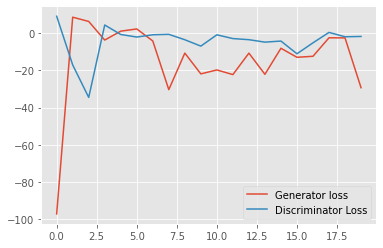

In [44]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig(path + 'loss.png')